## Read this

- https://s.id/PanduanPenggunaanDGXA100

## Import Libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
!pip install jupyter

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!pip uninstall traitlets --y
!pip install traitlets==5.9.0

Found existing installation: traitlets 5.9.0
Uninstalling traitlets-5.9.0:
  Successfully uninstalled traitlets-5.9.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 3.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

# from torchsummary import summary

## Download Model

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model_class = AutoModel.from_pretrained('bert-base-multilingual-uncased')

# Data collator is used for padding in batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Save Model to local - Example

In [4]:
# save_path = 'model/'
# !mkdir -p model

# model_class_path = os.path.join(save_path, "indobert_class"+".pth")

# torch.save(model_class, model_class_path)

## Load Model - Example

In [4]:
# save_path = 'model/'
# model_class_path = os.path.join(save_path, "indobert_class"+".pth")

# bert_class = torch.load(model_class_path)

bert_class = model_class

In [5]:
print(bert_class)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(105879, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

## Bert Test Simple Input

In [17]:
input = tokenizer("apa bedanya biru sama merah?")
print(input)
output = bert_class(torch.tensor(input['input_ids']).view(1, -1), return_dict=False)
output[0]

{'input_ids': [101, 20986, 42696, 10753, 73733, 14182, 37026, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


tensor([[[-8.2911e-02, -8.3153e-02,  3.1305e-02,  ..., -5.1345e-02,
          -8.2123e-02, -5.0736e-02],
         [-1.6626e-01,  3.8397e-01, -5.2482e-01,  ..., -5.6568e-04,
           3.3995e-01, -3.8834e-01],
         [-6.7141e-02, -2.8701e-01, -4.1661e-01,  ..., -1.7993e-01,
          -3.8352e-01, -3.1098e-01],
         ...,
         [-3.6483e-01, -1.7911e-01,  2.9843e-01,  ...,  1.7647e-02,
          -5.2252e-02, -1.7459e-01],
         [-2.9284e-01, -6.9461e-02, -4.8514e-02,  ..., -8.3409e-02,
           1.1530e-01, -5.1035e-01],
         [-6.3859e-01,  1.4862e-01, -3.2005e-01,  ...,  1.3915e-01,
          -2.4376e-01, -1.0357e+00]]], grad_fn=<NativeLayerNormBackward0>)

# Variables

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# LexID QA 2 Using BERT

## Dataset Class

In [7]:
class Lexidqa2Dataset(Dataset):
  """LexID QA2 Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    self.label2id = {"T1": 0, "T2": 1, "T3": 2, "T4": 3,
                "T5": 4, "T6": 5, "T7": 6, "T8": 7, "T9": 8,
                "T10": 9, "T11": 10, "T12": 11, "T13": 12,
                "T14": 13, "T15": 14, "T16": 15, "T17": 16, "T18": 17}
    self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
                4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
                9: "T10", 10: "T11", 11: "T12", 12: "T13",
                13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "question"]
    question_tokenized = tokenizer(question, truncation=True)
    question_input_ids = torch.tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "answer"]
    template_label = self.qa_frame.loc[idx, "template_index"]

    template_id = self.one_hot(template_label, self.label2id)

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              template_label,
              template_id)

    return sample

  def one_hot(self, label, label2id):
    one_hot_label = torch.zeros(len(label2id))
    one_hot_label[label2id[label]] = 1

    return one_hot_label

## Merging Dataset from Different csv

In [ ]:
t1 = pd.read_csv("tesaurus/t1_dataset_tesaurus.csv")
num, _ = t1.shape
num

12155

In [21]:
t = pd.DataFrame()
for i in range(1, 19):
  read_path = "tesaurus/t" + str(i) + "_dataset_tesaurus.csv"
  t_index = pd.read_csv(read_path)

  num_row, _ = t_index.shape
  two_thousands = np.min([2000, num_row])
  print("t" + str(i) + ": " + str(two_thousands))
  t = pd.concat([t, t_index[:two_thousands]], ignore_index=True)

t.head()

t1: 2000
t2: 2000
t3: 2000
t4: 2000
t5: 2000
t6: 2000
t7: 2000
t8: 2000
t9: 2000
t10: 2000
t11: 2000
t12: 2000
t13: 2000
t14: 314
t15: 955
t16: 2000
t17: 2000
t18: 2000


,question,answer,ner,legal_document,query,template_index,pasal_num,ayat_num
0,Peraturan Daerah Kota Semarang Nomor 6 Tahun 2...,H Sukawi Sutarip,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]",https://w3id.org/lex-id/data/Perkot_Semarang_2...,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
1,Pelegal dari Peraturan Presiden Republik Indon...,Joko Widodo,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]",https://w3id.org/lex-id/data/Perpres_2019_89,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
2,Peraturan Menteri Pertahanan Republik Indonesi...,Ryamizard Ryacudu,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]",https://w3id.org/lex-id/data/Permen_Han_2016_37,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
3,Keabsahan Peraturan Daerah Kabupaten Wakatobi ...,H U G U A,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]",https://w3id.org/lex-id/data/Perkab_Wakatobi_2...,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
4,Status Peraturan Pemerintah Republik Indonesia...,Dr Hamid Awaludin,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",https://w3id.org/lex-id/data/PP_2005_6,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN


## Dataset

In [22]:
qa_dataset = Lexidqa2Dataset(t, tokenizer)

## Sample from dataset

In [23]:
np.random.seed(12345)
random_indices = np.random.choice(range(len(qa_dataset)), size=5, replace=False)

for i in random_indices:
  sample = qa_dataset[i]

  print(i, sample[0])

  if i == 5:
    break

5710 Kapan terjadinya pengukugannya Peraturan Menteri Keuangan Republik Indonesia Nomor 204 Tahun 2015 ini keluar
21038 Apakah isi Pasal 2 dalam Peraturan Menteri Kelautan Dan Perikanan Republik Indonesia Nomor 25 Tahun 2012 itu
19978 Berapa jumlah pasal yang tersusun di Peraturan Pemerintah Republik Indonesia Nomor 26 Tahun 2016 tersebut
29131 Sudahkah Peraturan Daerah Provinsi Jawa Tengah Nomor 16 Tahun 2002 tersebut dilakukan penyempurnaan
26026 Peraturan Komisi Pemilihan Umum Republik Indonesia Nomor 10 Tahun 2015 tersebut terjadi penganuliran pasal-pasal mana saja


In [24]:
BATCH_SIZE = 64
torch.manual_seed(12345)

data_all_label = [qa_dataset[i][5] for i in range(len(qa_dataset))]
train_idx, test_idx = train_test_split(np.arange(len(qa_dataset)), test_size=0.25, random_state=12345, shuffle=True, stratify=data_all_label)

train_size = len(train_idx)
test_size = len(test_idx)

### Save train test data to CSV

In [ ]:
# train_df = t.iloc[train_idx]
# !mkdir -p dataset
# train_df.to_csv('dataset/train_tesaurus.csv', index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# test_df = t.iloc[test_idx]
# !mkdir -p dataset
# test_df.to_csv('dataset/test_tesaurus.csv', index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Split, DataLoader

In [8]:
def collate_fn_class(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, input_ids, _, _, _, _, label_ids = zip(*data)
    features = pad_sequence(input_ids, batch_first=True)
    targets = torch.stack(label_ids)
    return features, targets

### Prepare for KFold

### Load train test data

In [13]:
train_df = pd.read_csv('dataset/train_tesaurus.csv')
train_df['template_index'].value_counts()

T4     1500
T7     1500
T10    1500
T3     1500
T9     1500
T18    1500
T5     1500
T16    1500
T11    1500
T12    1500
T1     1500
T6     1500
T13    1500
T8     1500
T17    1500
T2     1500
T15     716
T14     235
Name: template_index, dtype: int64

In [27]:
test_df = pd.read_csv('dataset/test_tesaurus.csv')
test_df['template_index'].value_counts()

T17    500
T10    500
T13    500
T3     500
T2     500
T8     500
T11    500
T12    500
T4     500
T5     500
T9     500
T7     500
T18    500
T6     500
T1     500
T16    500
T15    239
T14     79
Name: template_index, dtype: int64

In [9]:
BATCH_SIZE = 64
torch.manual_seed(12345)

train_df = pd.read_csv('dataset/train_tesaurus.csv')
test_df = pd.read_csv('dataset/test_tesaurus.csv')

qa_dataset_train = Lexidqa2Dataset(train_df, tokenizer)
qa_dataset_test = Lexidqa2Dataset(test_df, tokenizer)

# data_all_label = [qa_dataset[i][5] for i in range(len(qa_dataset))]
# train_idx, test_idx = train_test_split(np.arange(len(qa_dataset)), test_size=0.25, random_state=12345, shuffle=True, stratify=data_all_label)

train_size = len(qa_dataset_train)
test_size = len(qa_dataset_test)

data_train_label = [qa_dataset_train[i][5] for i in range(train_size)]

# test_dataset = Subset(qa_dataset, test_idx)
test_instances = DataLoader(qa_dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

# Classification

## Model

### Loss Function

> Loss Function Multi-Class Classification: CrossEntropyLoss

In [10]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')

### Evaluation Function

In [11]:
def confusion_matrix(gold, pred, conf_matrix):
  _, gold = torch.max(gold, 1)
  _, pred = torch.max(pred, 1)
  for g, p in zip(gold.view(-1), pred.view(-1)):
    conf_matrix[g.long(), p.long()] += 1

  return conf_matrix

In [12]:
def evaluation_metric(conf_matrix):
  nb_classes = 18
  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']

  amt = amount(conf_matrix)
  # print(f"Debug Amount: {amt}")
  acc = accuracy(conf_matrix)
  prec = precision(conf_matrix)
  rec = recall(conf_matrix)
  f1 = fone(prec, rec)

  return amt, acc, prec, rec, f1

def amount(conf_matrix):
  return conf_matrix.sum(1)

def accuracy(conf_matrix):
  return conf_matrix.diag()/conf_matrix.sum(1)

def precision(conf_matrix):
  nb_classes = 18

  prec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_positive = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[col, index]
      else:
        false_positive += conf_matrix[col, index]
    prec[index] = true_positive / (true_positive + false_positive)

  return prec

def recall(conf_matrix):
  nb_classes = 18

  rec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_negative = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[index, col]
      else:
        false_negative += conf_matrix[index, col]
    rec[index] = true_positive / (true_positive + false_negative)

  return rec

def fone(prec, rec):
  nb_classes = 18

  f1 = torch.zeros(nb_classes)
  for index in range(nb_classes):
    f1[index] = 2 * (prec[index] * rec[index]) / (prec[index] + rec[index])

  return f1

### BERT + Full Connected Layer

In [13]:
class BERT_Lexidqa2_class(nn.Module):
    def __init__(self, bert, input_size = 768, output_size = 18):
        super().__init__()

        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu = nn.ReLU()

        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, output_size)

        self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
              4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
              9: "T10", 10: "T11", 11: "T12", 12: "T13",
              13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

    def forward(self, x):
        x, _ = self.bert(x, return_dict=False)

        # Only take the first column, Pooled Output, The Context
        x = x[:, 0, :]
        x = x.view(-1, 768)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)

        return x

    def predict(input):
      output = self.forward(torch.tensor(input['input_ids']).view(1, -1))

      id_max = torch.argmax(output)
      return self.id2label[id_max.item()]

In [14]:
model = BERT_Lexidqa2_class(bert_class, 768, 18)

## Training

> Train using 5-Fold
>
> Save checkpoint every 5 Epoch Max 20 Epoch

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====


0it [00:01, ?it/s]

Fold 1 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
==:==:==Train==:==:==: 0it [00:25, ?it/s]


Average Loss Train: 0.02690996645925518


==:==:==Valid==:==:==: 0it [00:04, ?it/s]
  5%|██▏                                         | 1/20 [00:30<09:35, 30.30s/it]

Average Loss Validation: 0.011684904951677608
Time 30.293490648269653

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:22, ?it/s]


Average Loss Train: 0.01151178148920407


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:55<08:09, 27.18s/it]

Average Loss Validation: 0.0071762621378855624
Time 24.992695093154907

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.008047641117969353


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [01:09<05:58, 21.11s/it]

Average Loss Validation: 0.005039151339224264
Time 13.885833501815796

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.006075050092054035


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [01:23<04:51, 18.24s/it]

Average Loss Validation: 0.0037934201241638255
Time 13.8129243850708

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004816761671123142


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.002963307929215749
Time 13.810908317565918



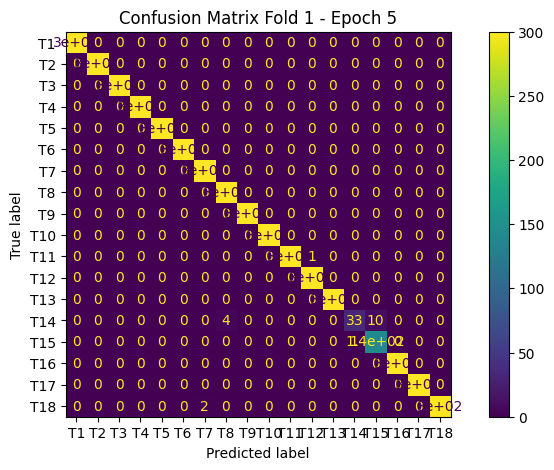

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,0.993378,1.000000,0.996678
T8,300.0,1.000000,0.986842,1.000000,0.993377
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 25%|███████████                                 | 5/20 [01:42<04:39, 18.62s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.003995595609616182


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:56<03:58, 17.05s/it]

Average Loss Validation: 0.002530292070621337
Time 14.012908458709717

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0034612872565019585


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [02:10<03:28, 16.07s/it]

Average Loss Validation: 0.002208632273154277
Time 14.046162843704224

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.003056714240319743


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [02:24<03:05, 15.48s/it]

Average Loss Validation: 0.0019632130577649748
Time 14.20350193977356

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0027366415517244167


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:38<02:45, 15.07s/it]

Average Loss Validation: 0.001772206949163023
Time 14.147645235061646

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002462019056141496


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0015935304213969843
Time 14.053222894668579



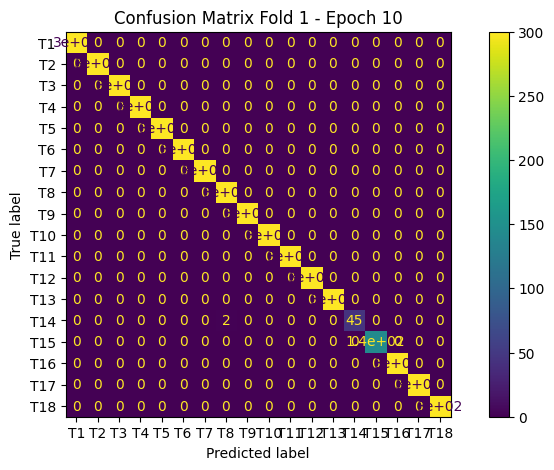

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.993378,1.000000,0.996678
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 50%|█████████████████████▌                     | 10/20 [02:57<02:43, 16.33s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0022425566943649776


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [03:12<02:20, 15.65s/it]

Average Loss Validation: 0.001451437895402142
Time 14.113188028335571

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0020465155331817323


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [03:26<02:01, 15.18s/it]

Average Loss Validation: 0.0013162693218892526
Time 14.08026385307312

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001862142856544507


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:40<01:43, 14.81s/it]

Average Loss Validation: 0.0012010873271668513
Time 13.955838441848755

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0017210269231117798


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:53<01:27, 14.54s/it]

Average Loss Validation: 0.0010955628000932761
Time 13.893950700759888

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0015572426277016829


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0010110308190214685
Time 14.008437156677246



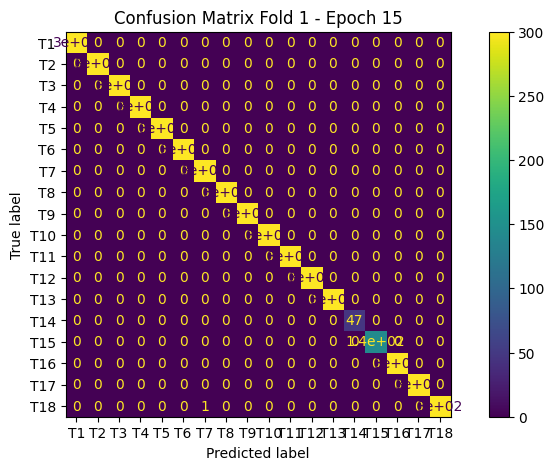

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,0.996678,1.000000,0.998336
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 75%|████████████████████████████████▎          | 15/20 [04:13<01:19, 15.93s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001448639710704406


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [04:27<01:01, 15.38s/it]

Average Loss Validation: 0.000920375551938103
Time 14.087013006210327

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0013306945050975125


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:41<00:44, 14.95s/it]

Average Loss Validation: 0.0008438442740608041
Time 13.952104806900024

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0012352375477880896


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:55<00:29, 14.67s/it]

Average Loss Validation: 0.0007763064119899901
Time 14.001562595367432

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0011280674315645603


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [05:09<00:14, 14.52s/it]

Average Loss Validation: 0.000706578444960456
Time 14.158195495605469

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0010350191019445599


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0006489072482420146
Time 14.131792783737183



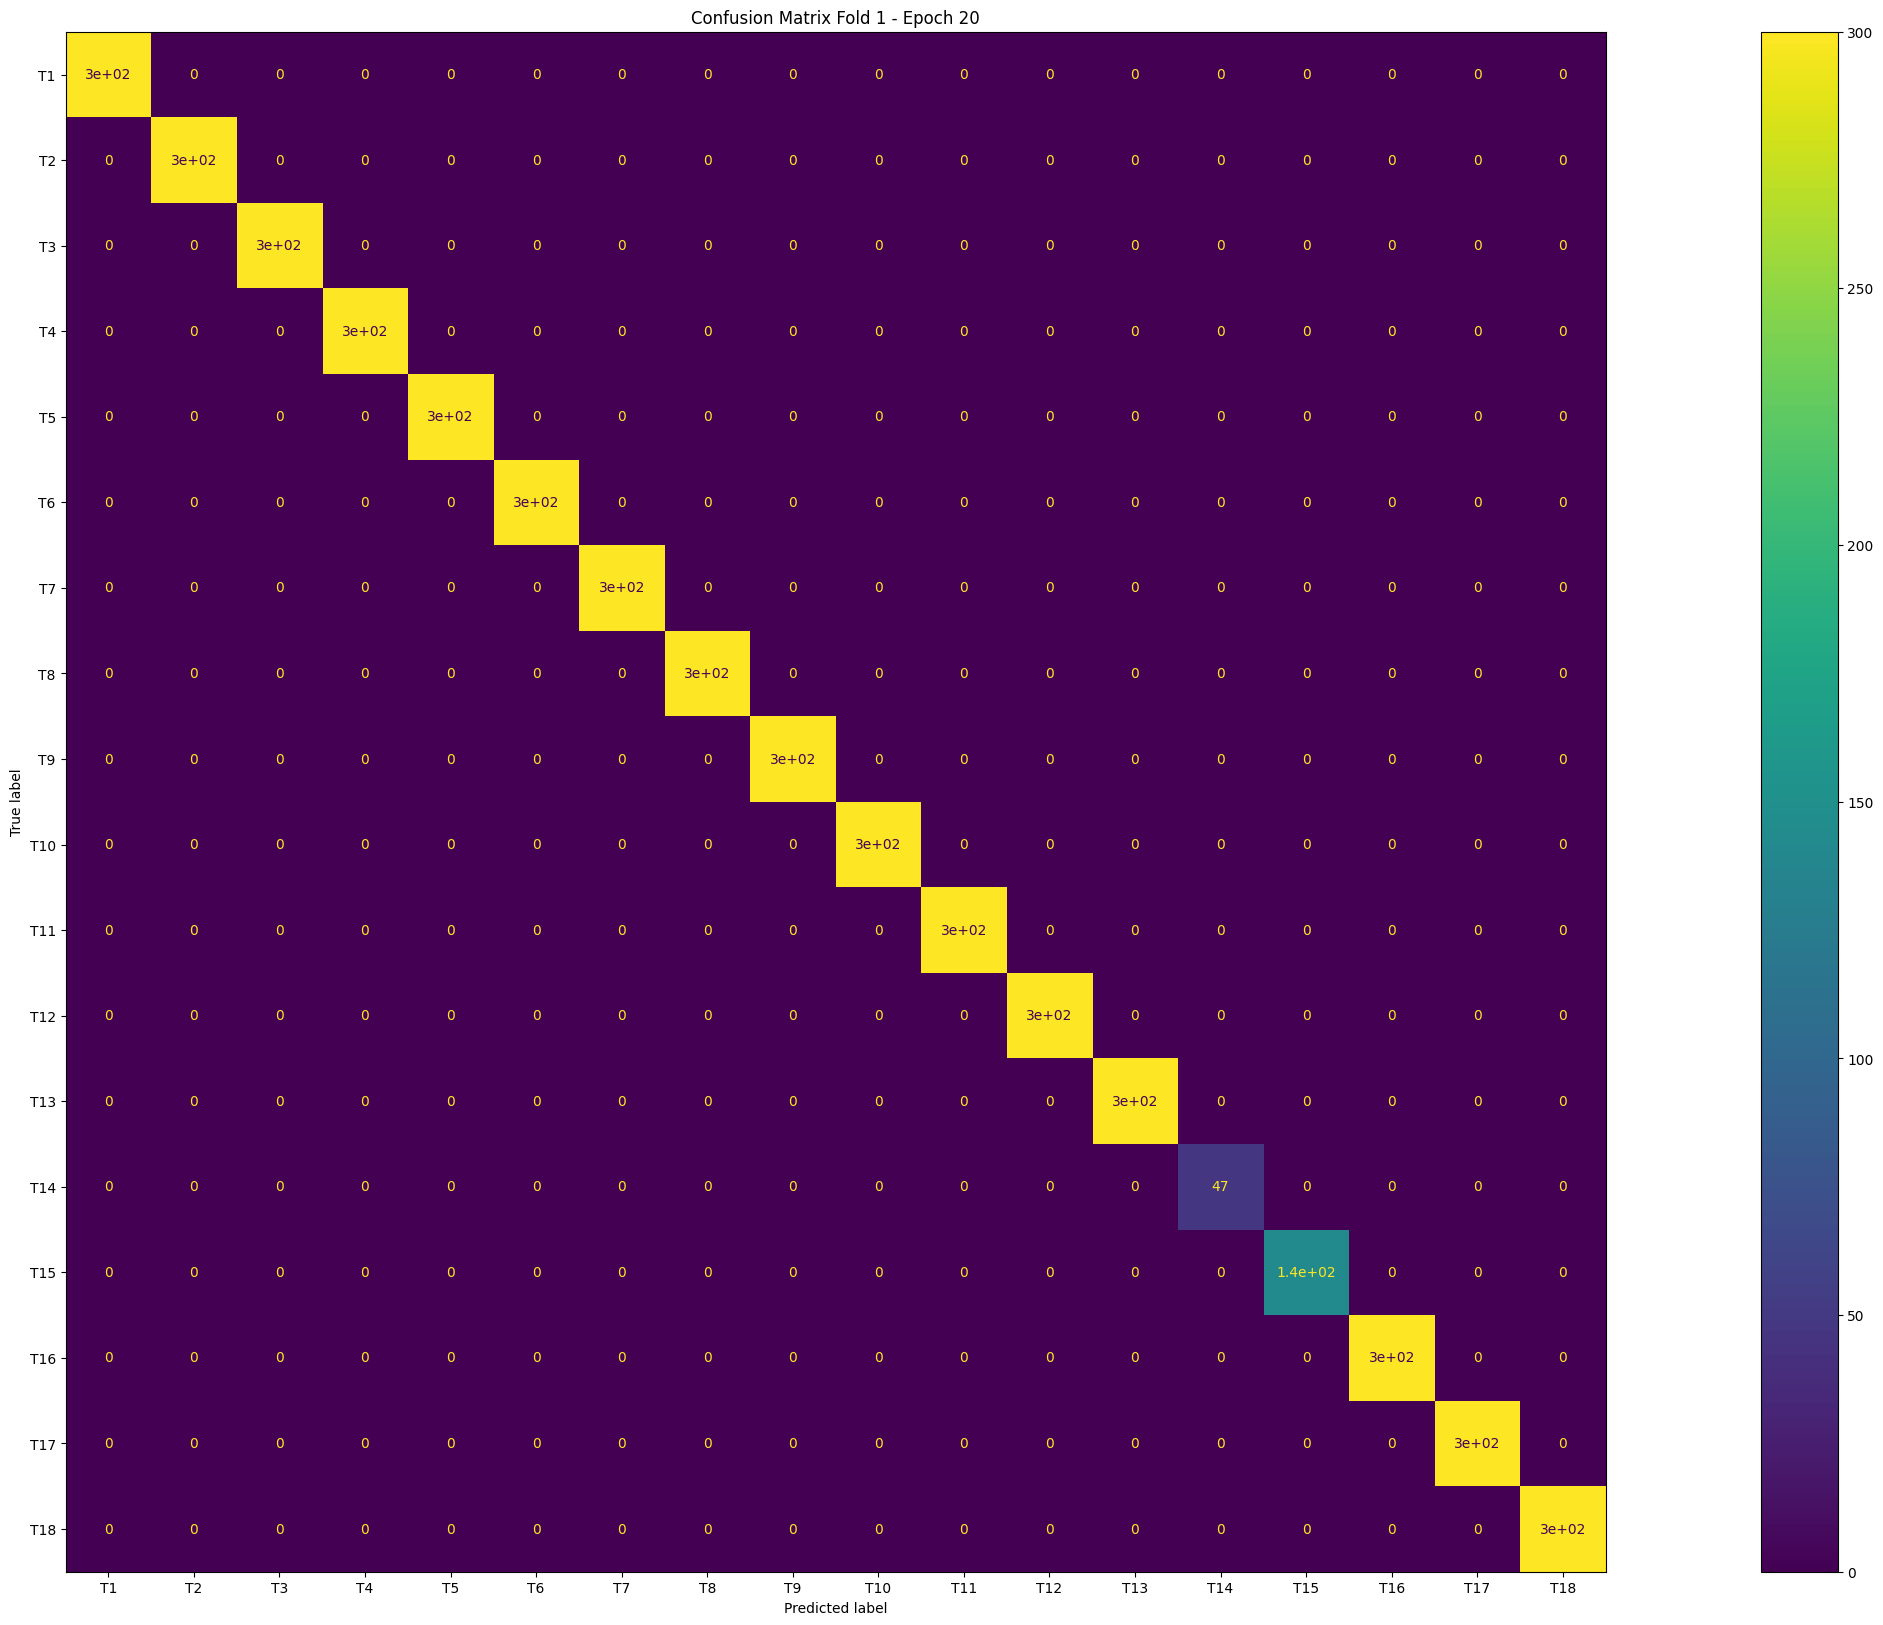

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.0,1.0,1.0,1.0
T2,300.0,1.0,1.0,1.0,1.0
T3,300.0,1.0,1.0,1.0,1.0
T4,300.0,1.0,1.0,1.0,1.0
T5,300.0,1.0,1.0,1.0,1.0
T6,300.0,1.0,1.0,1.0,1.0
T7,300.0,1.0,1.0,1.0,1.0
T8,300.0,1.0,1.0,1.0,1.0
T9,300.0,1.0,1.0,1.0,1.0
T10,300.0,1.0,1.0,1.0,1.0


100%|███████████████████████████████████████████| 20/20 [05:28<00:00, 16.44s/it]
1it [05:30, 330.58s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 2 =====:=====:=====:=====:=====


1it [05:31, 330.58s/it]

Fold 2 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.02759545908609198


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:14<04:27, 14.10s/it]

Average Loss Validation: 0.012276318699181199
Time 14.093327283859253

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.012318447825724839


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:28<04:14, 14.15s/it]

Average Loss Validation: 0.00860978229968008
Time 14.175728559494019

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.009046581365273726


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:42<04:01, 14.18s/it]

Average Loss Validation: 0.0057595438911824046
Time 14.21538782119751

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.00662349425989702


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:56<03:47, 14.22s/it]

Average Loss Validation: 0.004142867231775142
Time 14.256752014160156

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0052997393421703705


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0032323058567687362
Time 14.118556022644043



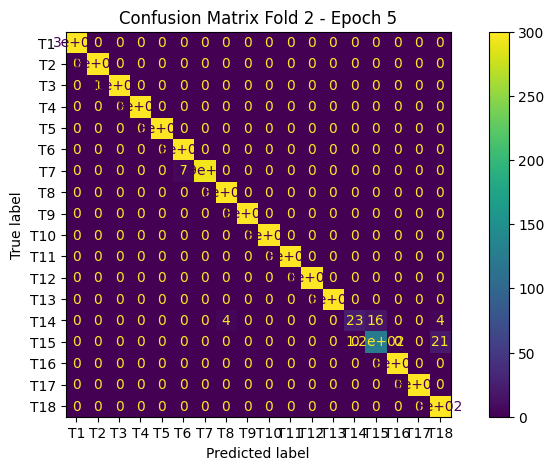

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,0.996678,1.000000,0.998336
T3,300.0,0.996667,1.000000,0.996667,0.998331
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,0.977199,1.000000,0.988468
T7,300.0,0.976667,1.000000,0.976667,0.988196
T8,300.0,1.000000,0.986842,1.000000,0.993377
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 25%|███████████                                 | 5/20 [01:16<04:03, 16.26s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004378510007614136


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:30<03:37, 15.50s/it]

Average Loss Validation: 0.0026168812850195324
Time 14.020304679870605

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0036849265785722763


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:44<03:15, 15.02s/it]

Average Loss Validation: 0.002264582830106089
Time 14.022676706314087

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0032340991124380127


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:58<02:55, 14.67s/it]

Average Loss Validation: 0.0019892277244575518
Time 13.89429259300232

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0029088213071574204


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:12<02:39, 14.51s/it]

Average Loss Validation: 0.0017834516872982224
Time 14.14443325996399

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002606458678661681


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0016096647164386834
Time 13.989269018173218



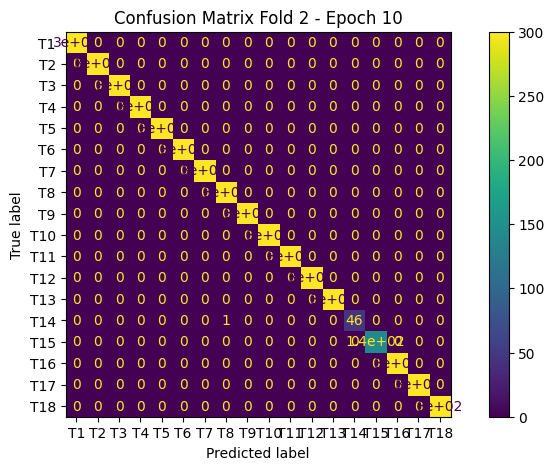

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.996678,1.000000,0.998336
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 50%|█████████████████████▌                     | 10/20 [02:32<02:40, 16.06s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002340972936408421


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:46<02:19, 15.49s/it]

Average Loss Validation: 0.0014599349387064726
Time 14.184382915496826

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0021415290252299176


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [03:00<02:00, 15.06s/it]

Average Loss Validation: 0.001317122303890083
Time 14.064252376556396

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0019621375837520025


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:14<01:43, 14.79s/it]

Average Loss Validation: 0.001213149442701397
Time 14.155354738235474

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001796466060776694


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:28<01:27, 14.58s/it]

Average Loss Validation: 0.001106962097252538
Time 14.089045286178589

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0016537626913085825


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.001007566011262561
Time 13.908689260482788



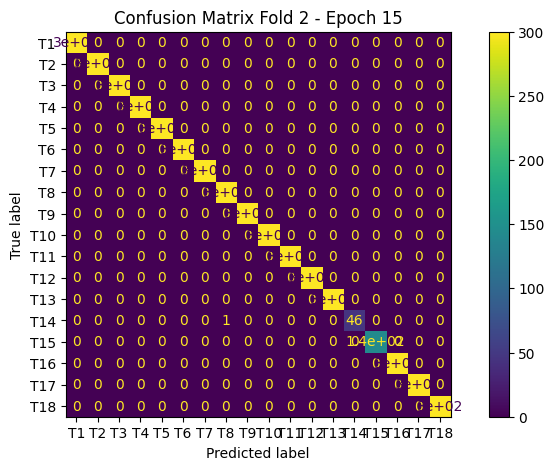

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.996678,1.000000,0.998336
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 75%|████████████████████████████████▎          | 15/20 [03:48<01:20, 16.19s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001526103464681348


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [04:02<01:02, 15.55s/it]

Average Loss Validation: 0.0009192904393993065
Time 14.068228483200073

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0013944571162654478


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:16<00:45, 15.08s/it]

Average Loss Validation: 0.0008386965281141545
Time 13.959280014038086

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0012791108234206621


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:30<00:29, 14.77s/it]

Average Loss Validation: 0.0007734084229371351
Time 14.057979106903076

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001170854763754515


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:44<00:14, 14.57s/it]

Average Loss Validation: 0.0007076795897885172
Time 14.08380675315857

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0010803922110157258


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0006488226406380743
Time 13.771143436431885



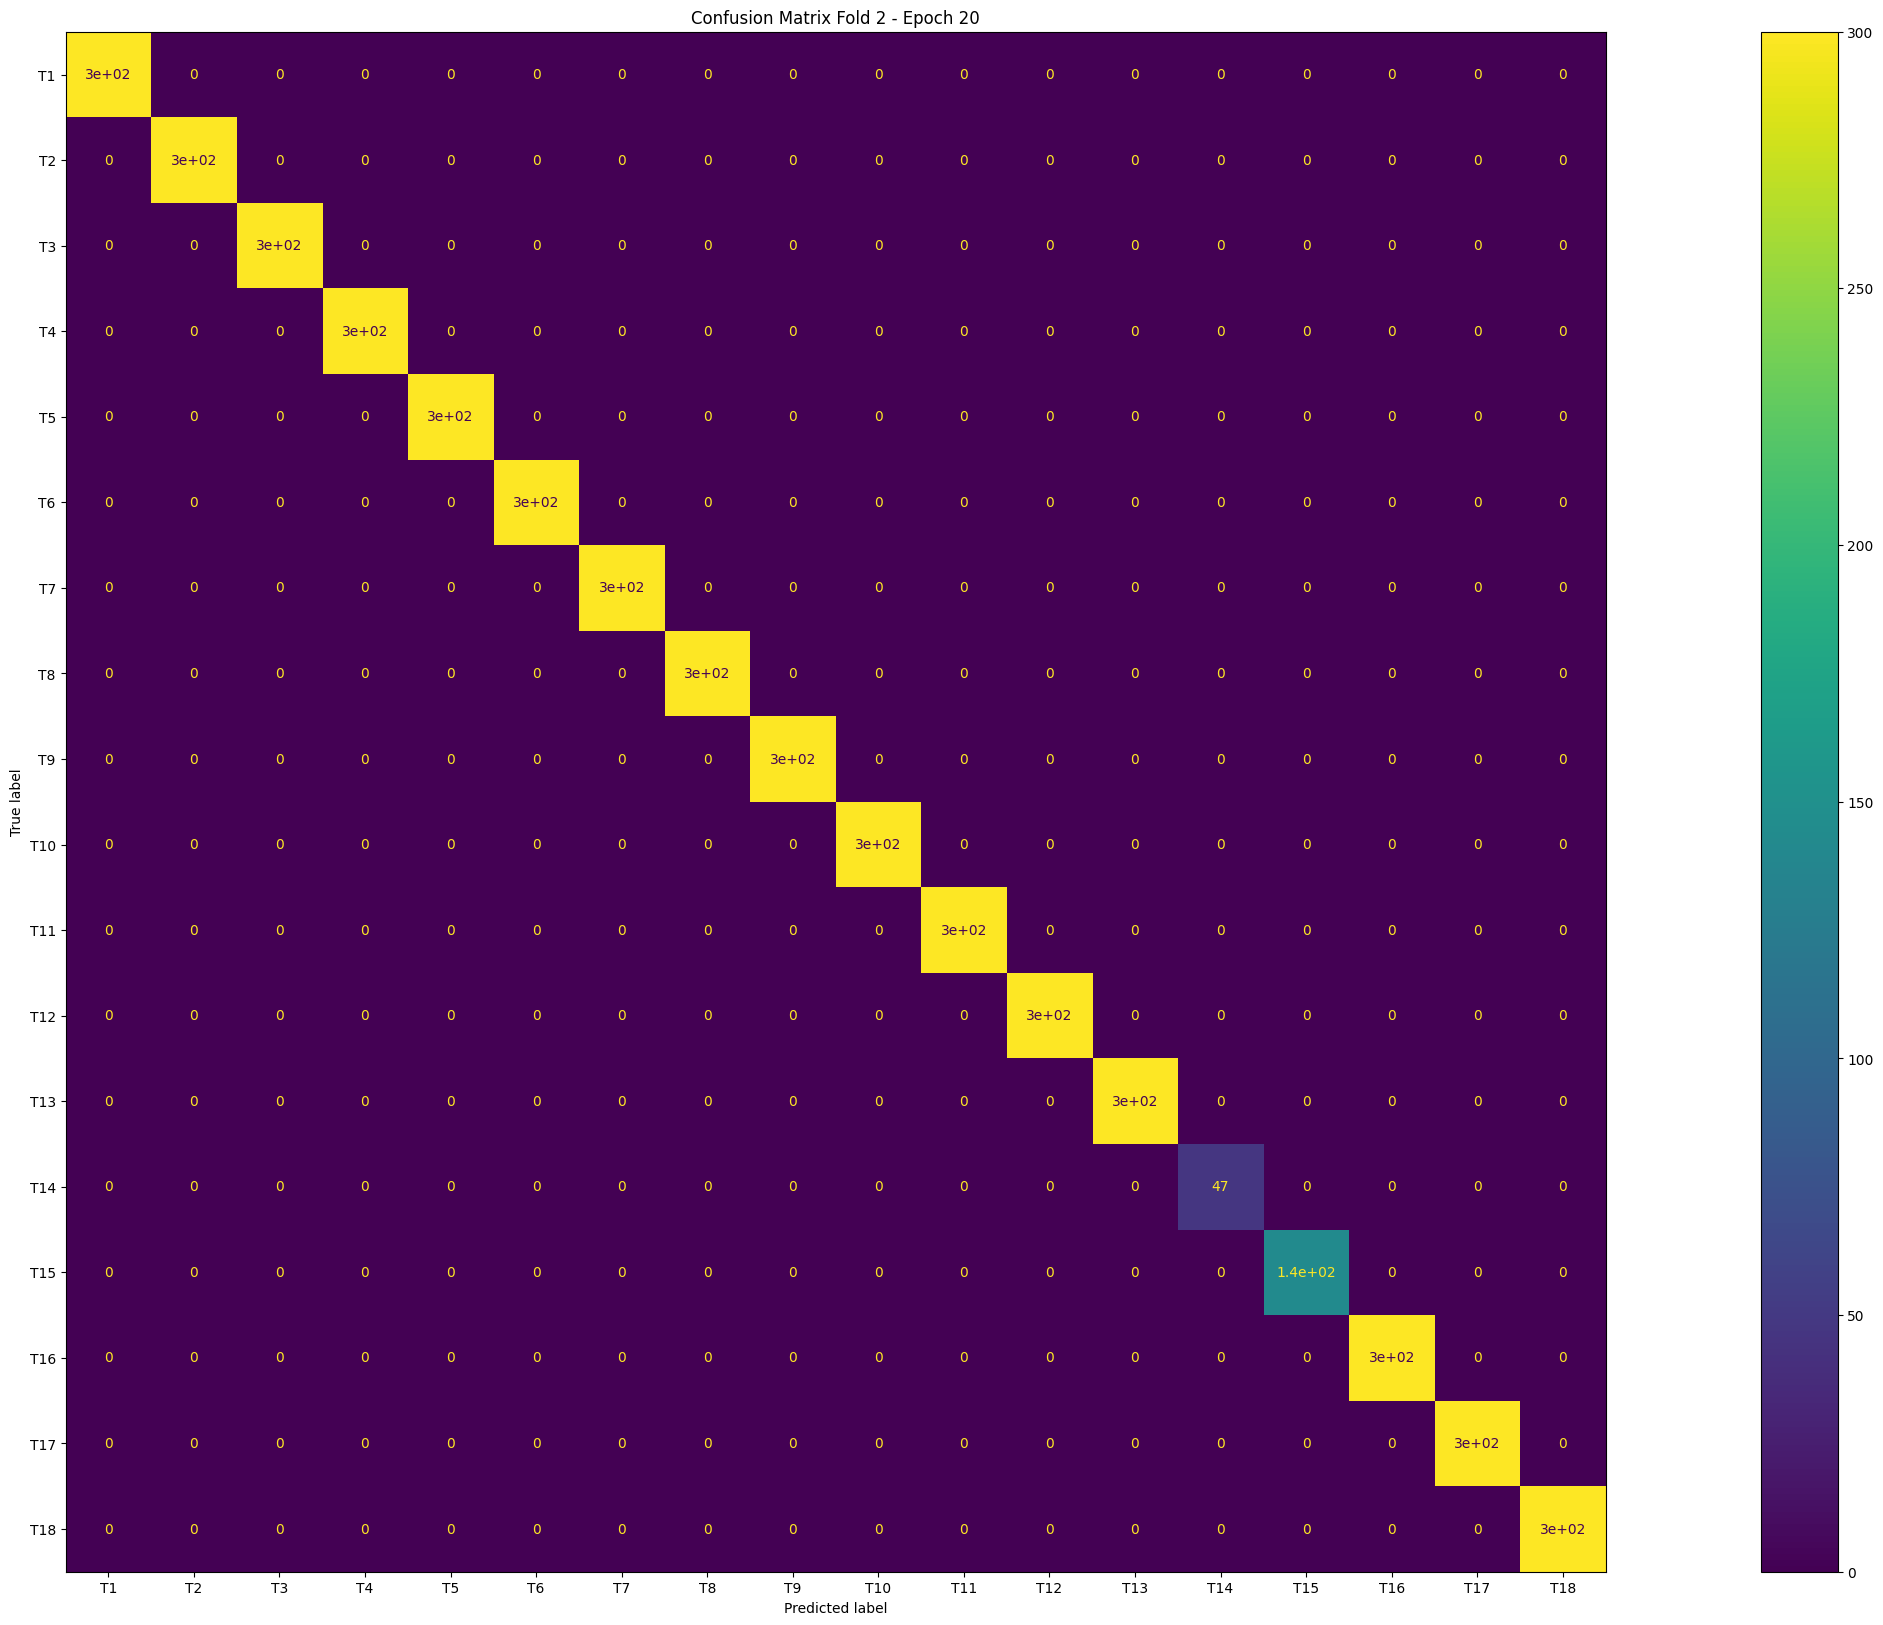

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.0,1.0,1.0,1.0
T2,300.0,1.0,1.0,1.0,1.0
T3,300.0,1.0,1.0,1.0,1.0
T4,300.0,1.0,1.0,1.0,1.0
T5,300.0,1.0,1.0,1.0,1.0
T6,300.0,1.0,1.0,1.0,1.0
T7,300.0,1.0,1.0,1.0,1.0
T8,300.0,1.0,1.0,1.0,1.0
T9,300.0,1.0,1.0,1.0,1.0
T10,300.0,1.0,1.0,1.0,1.0


100%|███████████████████████████████████████████| 20/20 [05:04<00:00, 15.25s/it]
2it [10:36, 316.23s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 3 =====:=====:=====:=====:=====


2it [10:38, 316.23s/it]

Fold 3 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.027346788717112904


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:14<04:29, 14.19s/it]

Average Loss Validation: 0.01231037151359604
Time 14.18282437324524

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.012256582961233673


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:28<04:15, 14.18s/it]

Average Loss Validation: 0.007845764617642801
Time 14.158672332763672

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.00875197193539099


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:42<03:59, 14.12s/it]

Average Loss Validation: 0.005559410623653618
Time 14.038400888442993

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.006595159689569442


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:56<03:46, 14.13s/it]

Average Loss Validation: 0.004131308547361103
Time 14.134042978286743

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.005183321943168894


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0032605430555486966
Time 14.145365953445435



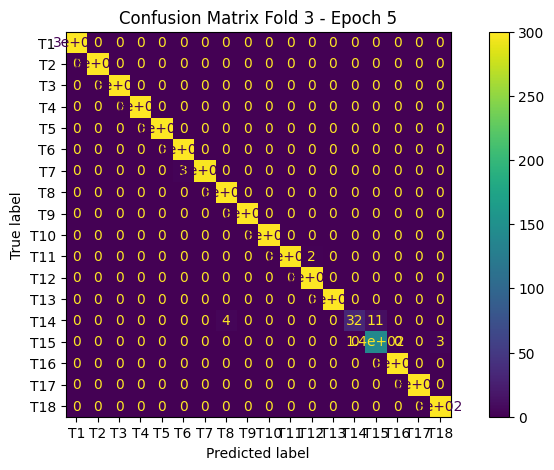

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,0.990099,1.000000,0.995025
T7,300.0,0.990000,1.000000,0.990000,0.994975
T8,300.0,1.000000,0.986842,1.000000,0.993377
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 25%|███████████                                 | 5/20 [01:16<04:05, 16.34s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004351015852028093


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:31<03:39, 15.69s/it]

Average Loss Validation: 0.0027771562755944017
Time 14.424500942230225

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0037816825489512687


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:45<03:18, 15.25s/it]

Average Loss Validation: 0.0024447895004180726
Time 14.34163522720337

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0033437162055429837


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:59<02:58, 14.88s/it]

Average Loss Validation: 0.0021708125939111193
Time 14.08285665512085

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.003004910451132873


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:13<02:40, 14.61s/it]

Average Loss Validation: 0.0019529012063581623
Time 13.989462614059448

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0027253104299254614


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0017732160781810662
Time 14.050665855407715



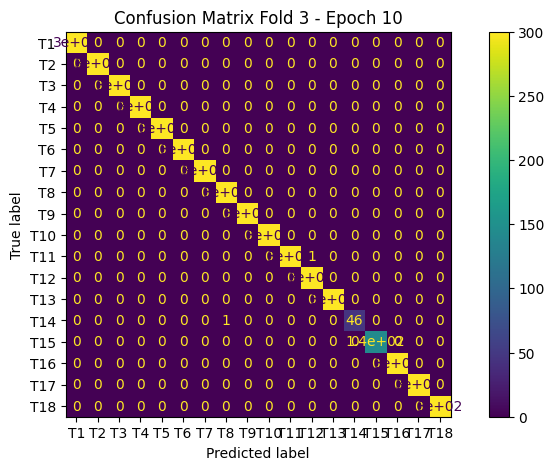

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.996678,1.000000,0.998336
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 50%|█████████████████████▌                     | 10/20 [02:33<02:41, 16.19s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002469128955253218


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:47<02:19, 15.52s/it]

Average Loss Validation: 0.0016159327465570523
Time 13.982794761657715

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0022564764953371483


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [03:01<02:00, 15.03s/it]

Average Loss Validation: 0.0014741629615933718
Time 13.907484531402588

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0020704570713331546


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:15<01:43, 14.72s/it]

Average Loss Validation: 0.0013518162355394307
Time 13.985071659088135

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0018985675758245528


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:29<01:27, 14.51s/it]

Average Loss Validation: 0.0012314278669729977
Time 14.021891117095947

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001738403582046197


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0011475274134016705
Time 13.911245584487915



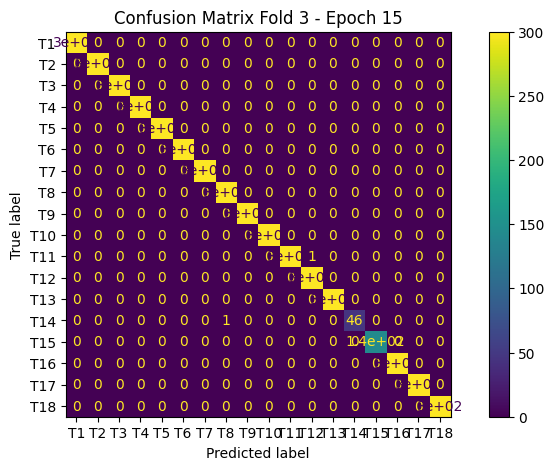

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.996678,1.000000,0.998336
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 75%|████████████████████████████████▎          | 15/20 [03:49<01:20, 16.15s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0016108464691701177


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [04:03<01:02, 15.56s/it]

Average Loss Validation: 0.001038720097415194
Time 14.195796489715576

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0014968109287030055


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:17<00:45, 15.13s/it]

Average Loss Validation: 0.000954677298187254
Time 14.13038945198059

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001386668928552442


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:31<00:29, 14.84s/it]

Average Loss Validation: 0.0008744399778111903
Time 14.141570091247559

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001268030575339275


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:45<00:14, 14.62s/it]

Average Loss Validation: 0.0008025214852455384
Time 14.101069927215576

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001165037070033868


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0007443575640181024
Time 14.13253664970398



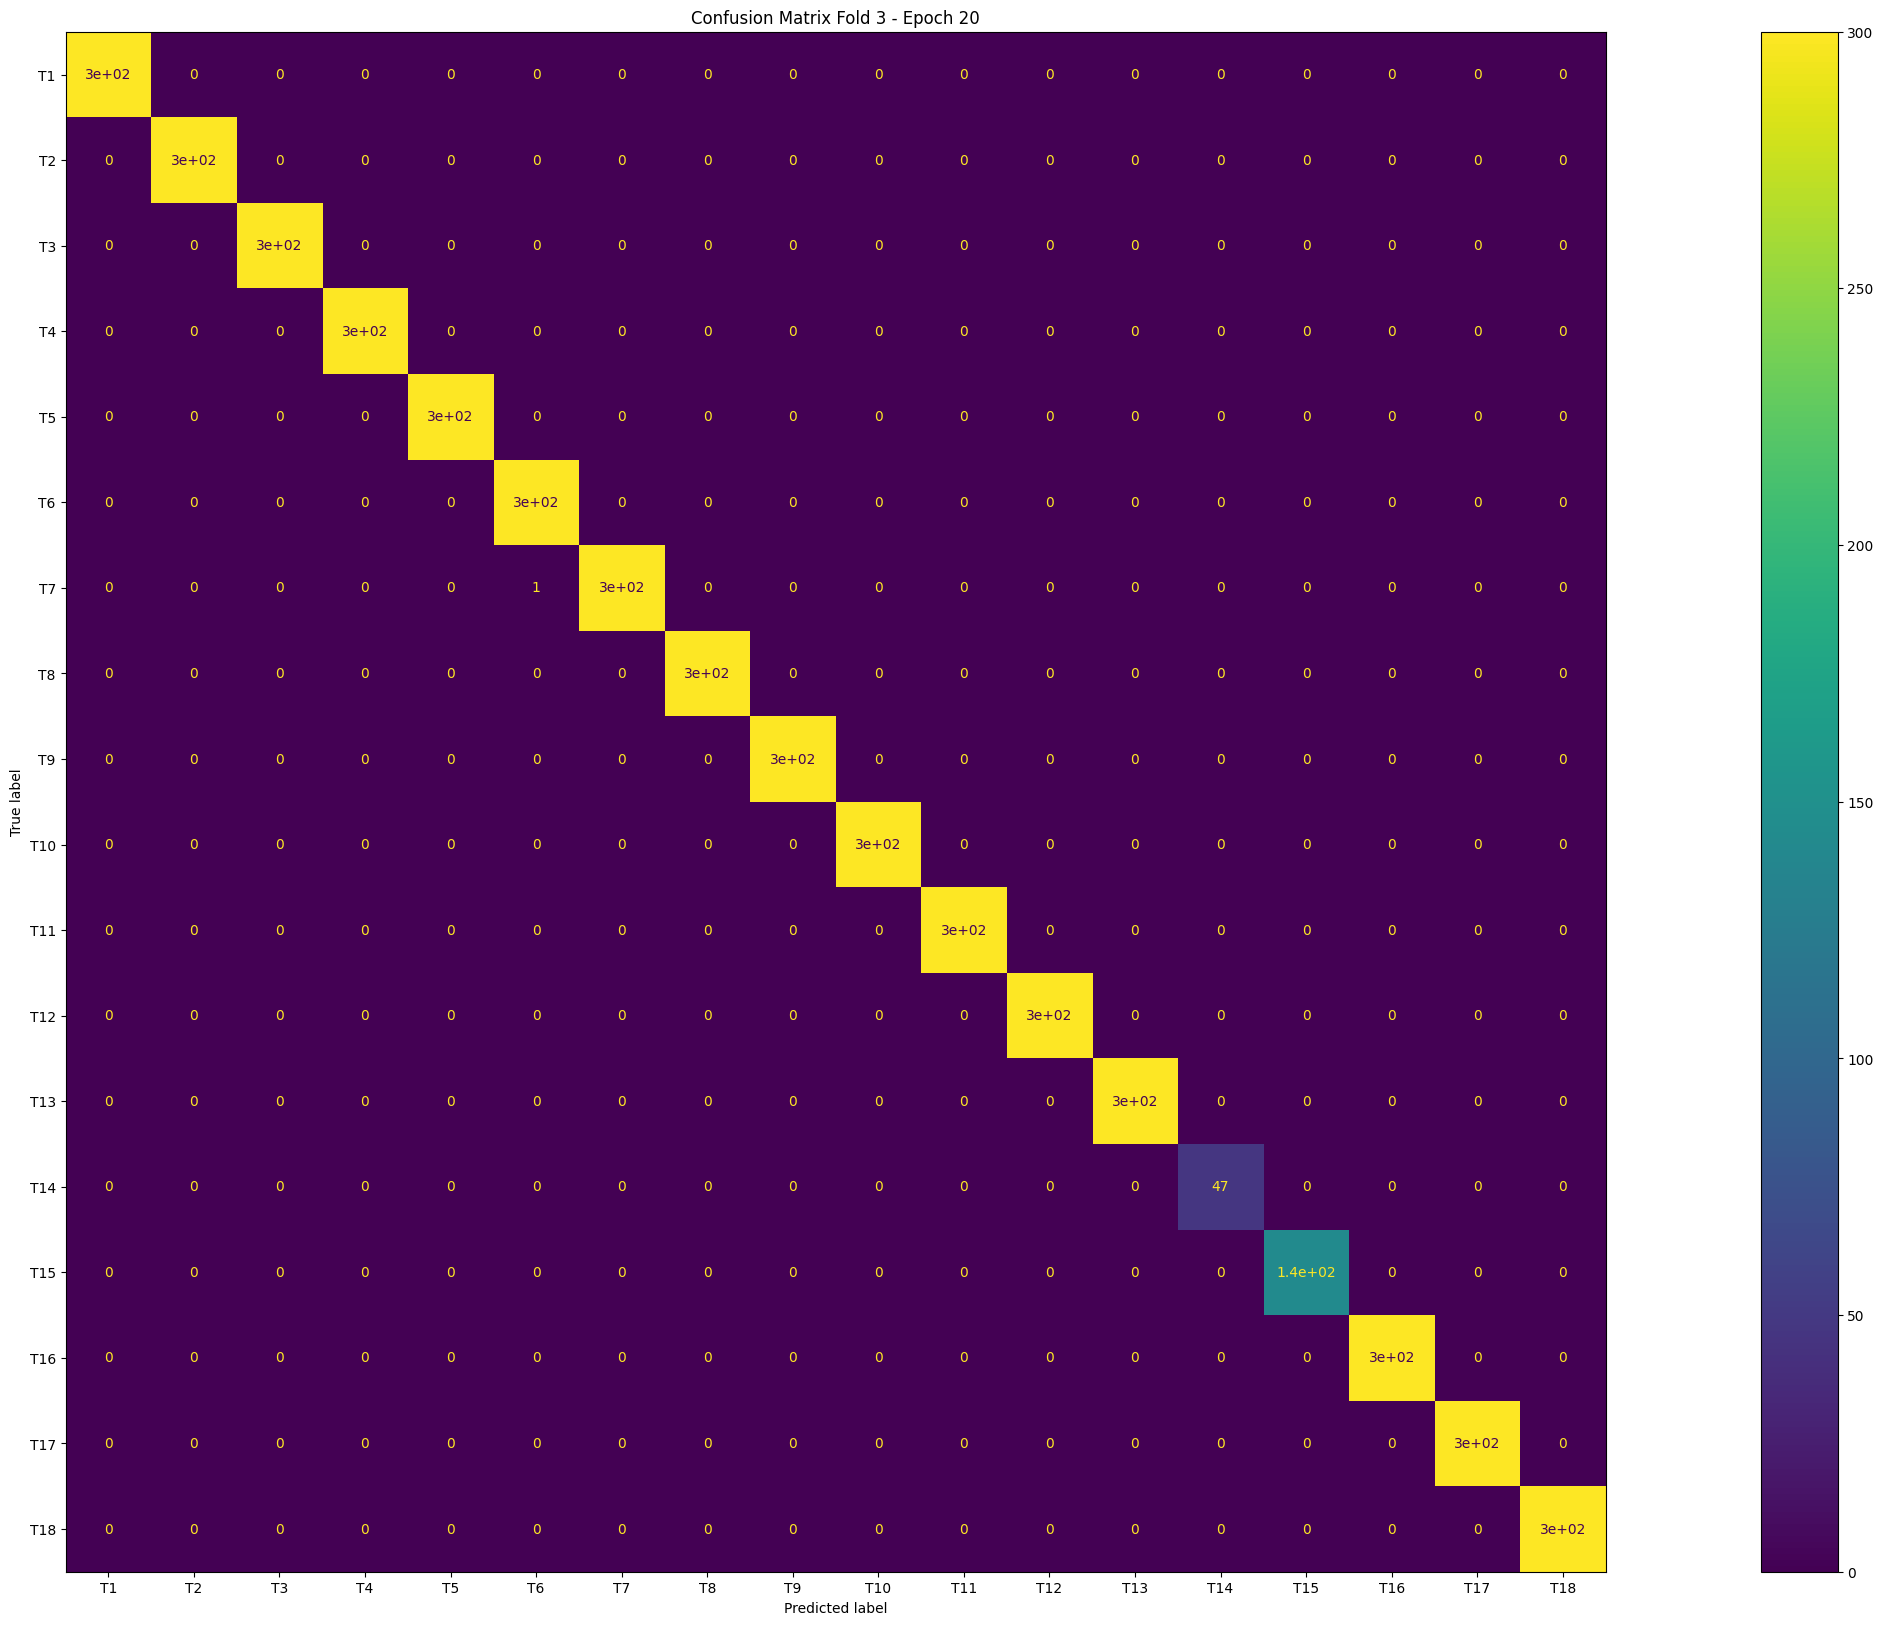

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,0.996678,1.000000,0.998336
T7,300.0,0.996667,1.000000,0.996667,0.998331
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


100%|███████████████████████████████████████████| 20/20 [05:06<00:00, 15.31s/it]
3it [15:44, 312.24s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 4 =====:=====:=====:=====:=====


3it [15:48, 312.24s/it]

Fold 4 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.026906101042889537


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:14<04:29, 14.18s/it]

Average Loss Validation: 0.011703192399355597
Time 14.167509078979492

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.011476233974080496


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:28<04:16, 14.26s/it]

Average Loss Validation: 0.0067520946025370595
Time 14.312933921813965

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.007693863800105778


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:42<04:01, 14.22s/it]

Average Loss Validation: 0.004591470129623681
Time 14.159882307052612

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.005854658584282743


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:56<03:47, 14.21s/it]

Average Loss Validation: 0.003526885753762507
Time 14.188602685928345

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0047609001050211135


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0029477862951034057
Time 13.9759681224823



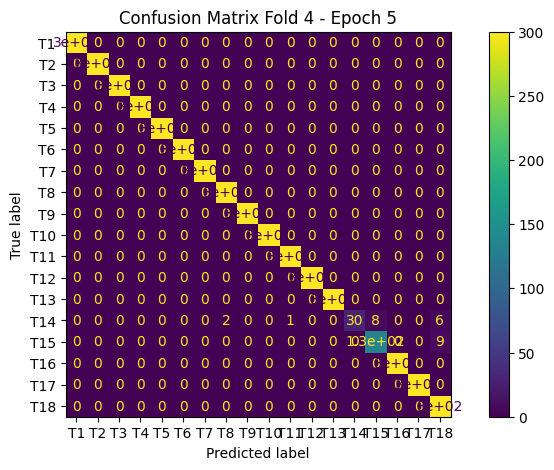

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.993378,1.000000,0.996678
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 25%|███████████                                 | 5/20 [01:17<04:06, 16.40s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0040464019477979545


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:31<03:38, 15.62s/it]

Average Loss Validation: 0.002476086355521827
Time 14.08480191230774

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.00347707306632214


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:45<03:16, 15.10s/it]

Average Loss Validation: 0.0021765242299001536
Time 14.018283367156982

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0030747387892473355


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:59<02:57, 14.81s/it]

Average Loss Validation: 0.0019299673502574226
Time 14.193044900894165

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0027117174475030942


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:13<02:40, 14.63s/it]

Average Loss Validation: 0.0017419515054426596
Time 14.23375940322876

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002462138898249266


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0015676694785903595
Time 14.121222734451294



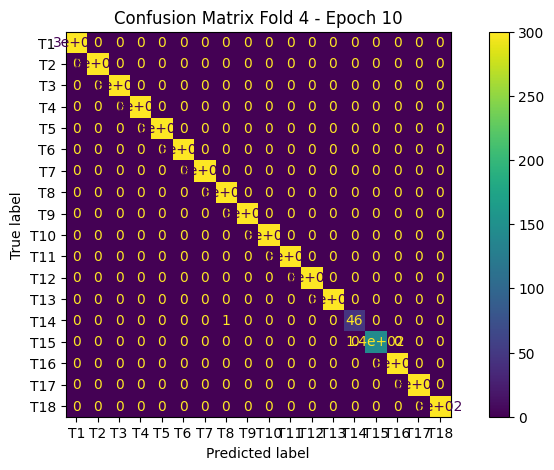

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.996678,1.000000,0.998336
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 50%|█████████████████████▌                     | 10/20 [02:33<02:43, 16.33s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0022430984510232845


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:47<02:20, 15.57s/it]

Average Loss Validation: 0.0014253162638935633
Time 13.848509550094604

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002056739372962475


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [03:01<02:00, 15.10s/it]

Average Loss Validation: 0.0012926142491056828
Time 14.008697509765625

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0018662247999201413


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:15<01:43, 14.79s/it]

Average Loss Validation: 0.0011836688316059494
Time 14.07323932647705

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0017055122312506408


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:29<01:27, 14.56s/it]

Average Loss Validation: 0.0010851326307098946
Time 14.021392107009888

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0015773445272259348


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0009883641039500973
Time 13.864947319030762



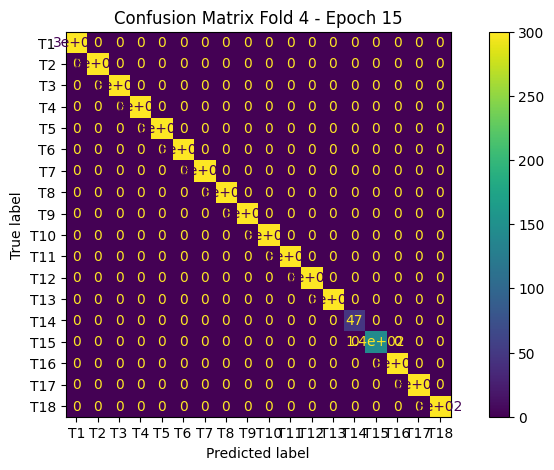

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.0,1.0,1.0,1.0
T2,300.0,1.0,1.0,1.0,1.0
T3,300.0,1.0,1.0,1.0,1.0
T4,300.0,1.0,1.0,1.0,1.0
T5,300.0,1.0,1.0,1.0,1.0
T6,300.0,1.0,1.0,1.0,1.0
T7,300.0,1.0,1.0,1.0,1.0
T8,300.0,1.0,1.0,1.0,1.0
T9,300.0,1.0,1.0,1.0,1.0
T10,300.0,1.0,1.0,1.0,1.0


 75%|████████████████████████████████▎          | 15/20 [03:50<01:21, 16.33s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0014488680262907457


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [04:04<01:02, 15.65s/it]

Average Loss Validation: 0.000904569506854237
Time 14.08056902885437

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0013306921730657348


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:18<00:45, 15.18s/it]

Average Loss Validation: 0.0008402281763677846
Time 14.075072288513184

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]

In [ ]:
import time
torch.manual_seed(12345)

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 20

model.to(DEVICE)

training_losses = [[] for i in range(5)]
validation_losses = [[] for i in range(5)]

skf = StratifiedKFold(n_splits=5)

# Load before training + validing
for fold_i, (train_index, val_index) in enumerate(tqdm(skf.split(np.zeros(len(qa_dataset_train)), data_train_label), position=0, leave=True)):
  tqdm.write(f"=====:=====:=====:=====:===== Fold {fold_i + 1} =====:=====:=====:=====:=====")

  # Subset dataset for train and val
  train_dataset = Subset(qa_dataset_train, train_index)
  valid_dataset = Subset(qa_dataset_train, val_index)

  train_size = len(train_dataset)
  valid_size = len(valid_dataset)

  train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  model_class = AutoModel.from_pretrained('bert-base-multilingual-uncased')
  bert_class = model_class
  model = BERT_Lexidqa2_class(bert_class, 768, 18)
  model.to(DEVICE)

  # optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

  tqdm.write(f'Fold {fold_i + 1} Ready')

  for epoch_i in tqdm(range(0, EPOCH), position=0, leave=True):
    start = time.time()
    tqdm.write(f"Epoch {epoch_i + 1} / {EPOCH}")

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last layer
    for param in model.bert.encoder.layer[11].parameters():
        param.requires_grad = True

    # Reset the total loss for this epoch.
    tr_loss = 0

    # Put the model into training mode.
    model.train()

    # Untuk setiap data di training data
    train_total_data = train_size
    train_pbar = tqdm(desc="==:==:==Train==:==:==", position=0, leave=True)
    for data in train_instances:

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # Agar gradient tidak menumpuk; ini diperlukan sebelum
      # menghitung gradient dengan loss.backward()
      optimizer.zero_grad()

      # hitung gradient
      loss.backward()

      # update parameter
      optimizer.step()

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      # train_pbar.update(len(data))

    # rata-rata loss dalam 1 epoch
    avg_loss = tr_loss / train_total_data

    training_losses[fold_i].append(avg_loss)

    train_pbar.write(f"Average Loss Train: {avg_loss}")

    train_pbar.close()

    ### Uji coba di Validation Data

    # model eval, agar layer seperti dropout yang menghasilkan
    # sesuai yang random tidak digunakan
    model.eval()

    val_loss = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    valid_total_data = valid_size
    valid_pbar = tqdm(desc="==:==:==Valid==:==:==", position=0, leave=True)
    for data in valid_instances:

      # jangan track gradient! ini sedang evaluasi, bukan training
      with torch.no_grad():

        # Mendapatkan output dari model
        input, gold = data
        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)

        # Categorical Cross-Entropy --- Loss Function
        loss = loss_func(pred, gold)

        # akumulasi loss di validation set
        val_loss += loss.item()

        # valid_pbar.update(len(data))


    # average loss
    avg_val_loss = val_loss / valid_total_data

    validation_losses[fold_i].append(avg_val_loss)

    valid_pbar.write(f"Average Loss Validation: {avg_val_loss}")

    end = time.time()
    valid_pbar.write("Time " + str(end-start))
    valid_pbar.write("")
    valid_pbar.close()

    # accuracy
    # pred_labels = torch.stack(pred_labels).numpy()
    # true_labels = torch.stack(true_labels).numpy()
    # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
    # print(f"Accuracy di validation data: {val_accuracy}")


    if (epoch_i + 1) % 5 == 0:
      nb_classes = 18

      conf_matrix = torch.zeros(nb_classes, nb_classes)
      with torch.no_grad():
        for i, (input, gold) in enumerate(valid_instances):
          input = input.to(DEVICE)
          gold = gold.to(DEVICE)
          pred = model(input)
          # _, gold = torch.max(gold, 1)
          # _, pred = torch.max(pred, 1)
          # for t, p in zip(gold.view(-1), pred.view(-1)):
          #   conf_matrix[t.long(), p.long()] += 1

          conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
      data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }


      fig, ax = _, _
      if (epoch_i + 1) != EPOCH:
        fig, ax = plt.subplots(figsize=(10, 5))
      else:
        fig, ax = plt.subplots(figsize=(40, 20))

      display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
      disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
      disp.plot(ax=ax)
      plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch {epoch_i + 1}")
      plt.show()

      disp_df = pd.DataFrame(data=data_conf,
                             index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
      display(disp_df)

      # for i, template_index in enumerate(display_labels):
      #   print(f"Evaluation for {template_index}:")
      #   print(f"Amount of Data: {amt[i]}")
      #   print(f"Accuracy: {acc[i]}")
      #   print(f"Precision: {prec[i]}")
      #   print(f"Recall: {rec[i]}")
      #   print(f"F One: {f1[i]}")
      #   print()

      model.to("cpu")

      save_path = 'model_multilingualbert/class_tesaurus_checkpoint/fold_' + str(fold_i)
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      model_class_path = os.path.join(save_path, "multilingualbert_class_tesaurus_checkpoint_" + str(epoch_i) +".pth")
      torch.save(model, model_class_path)

      model.to(DEVICE)

### Visualize

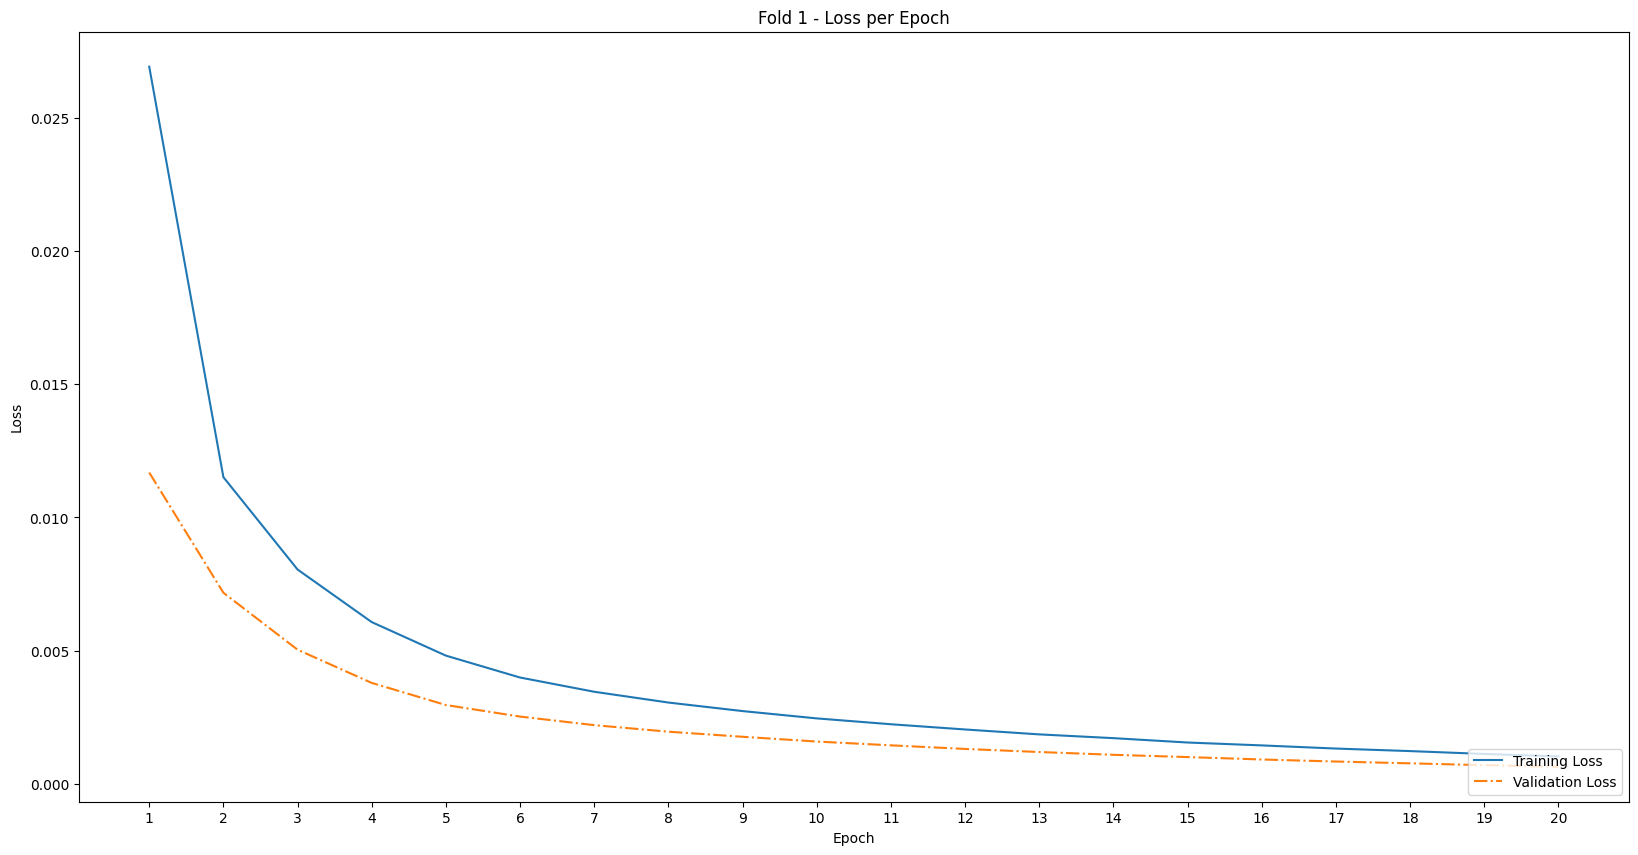

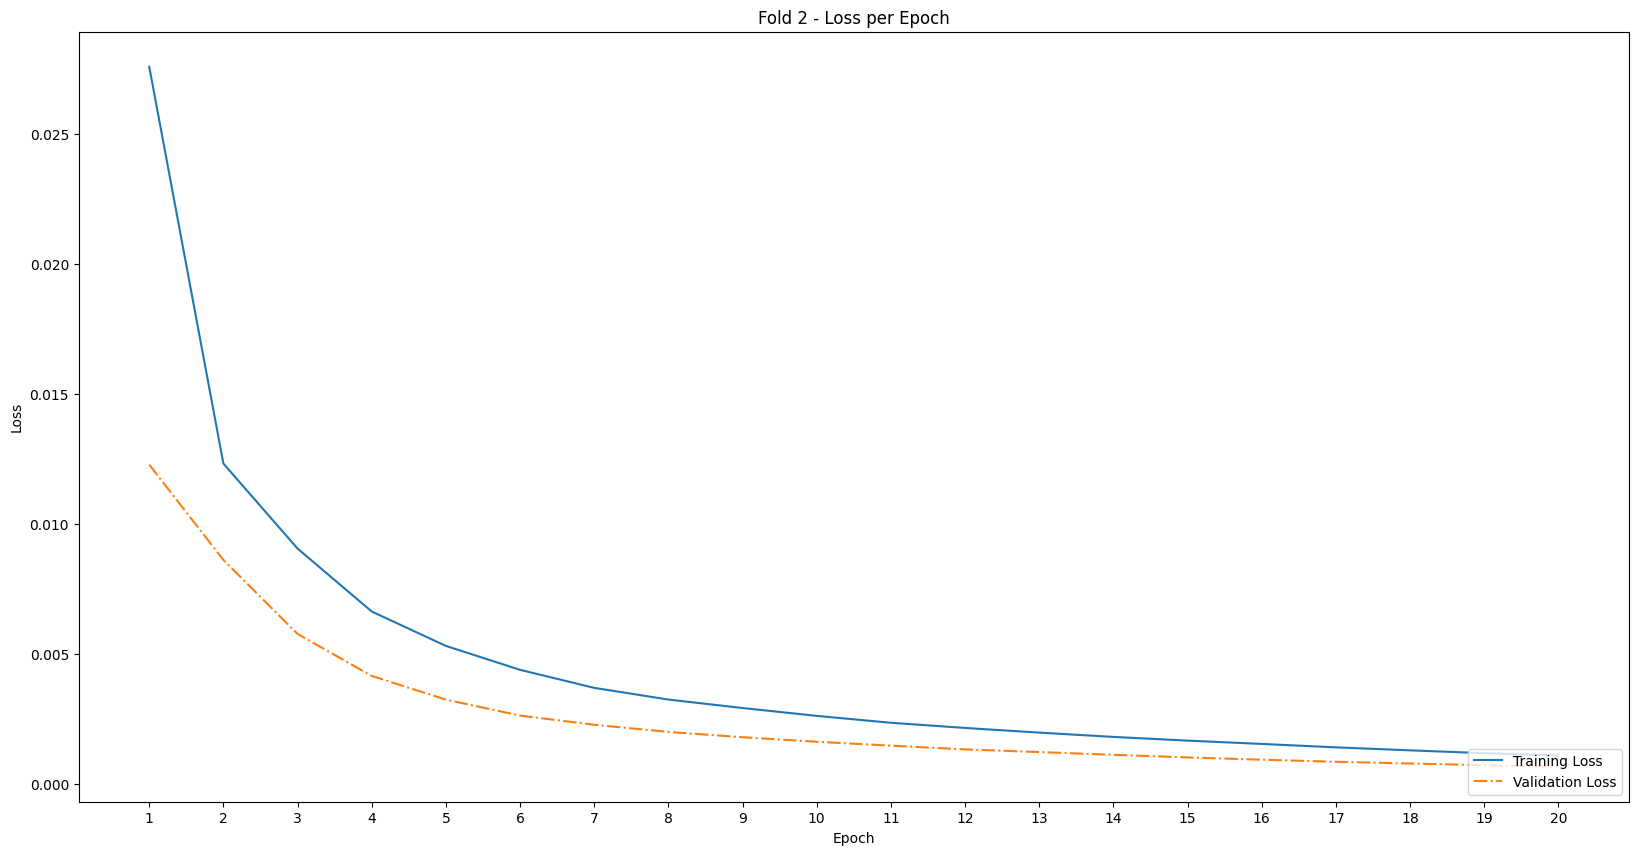

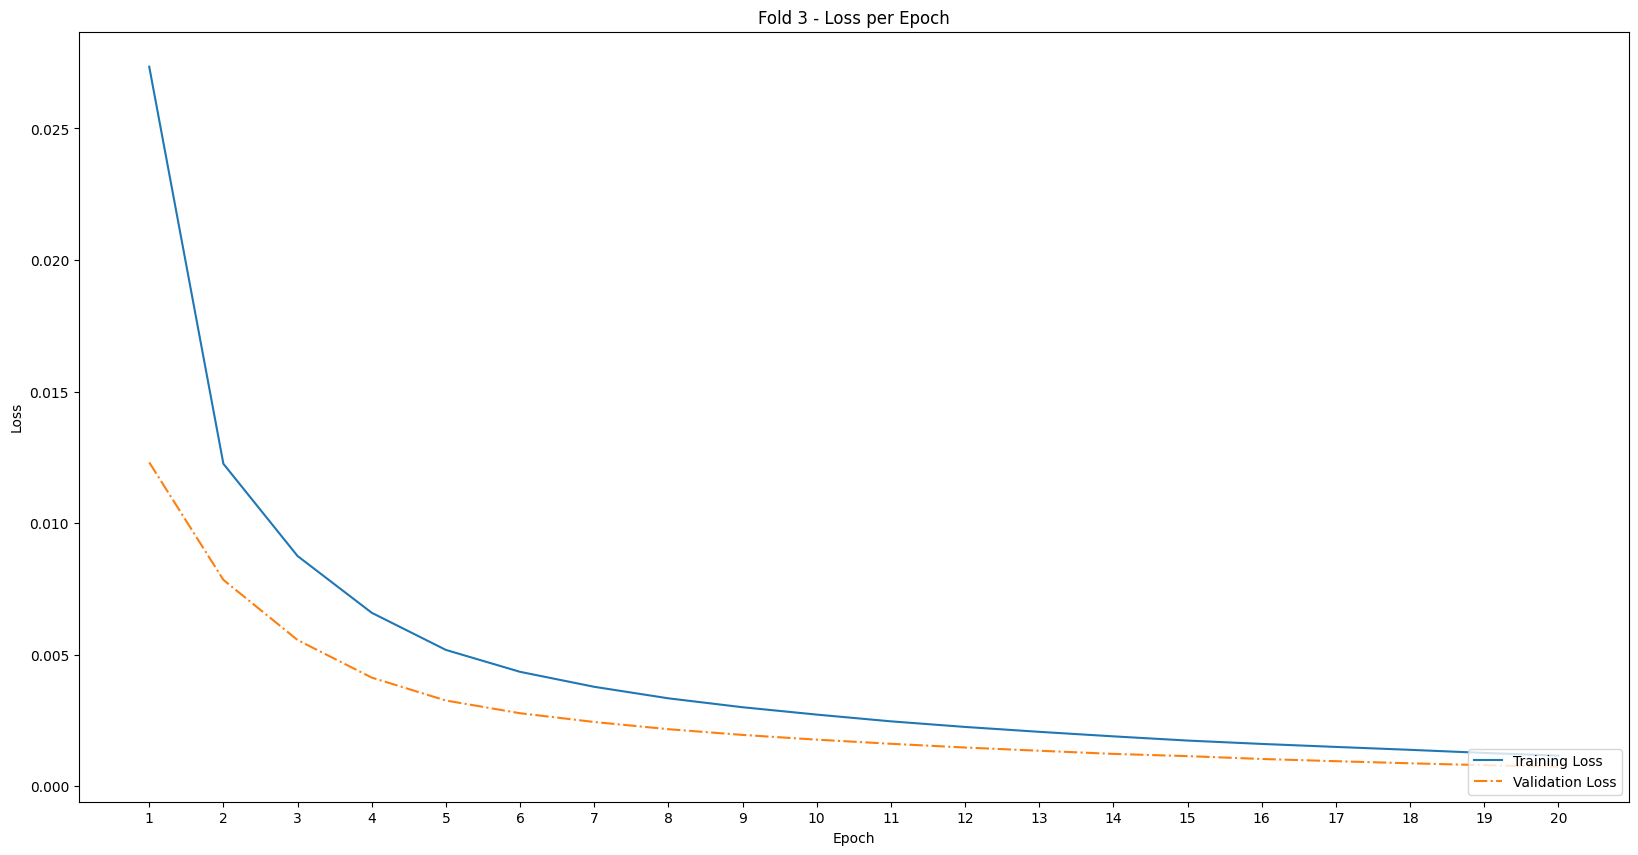

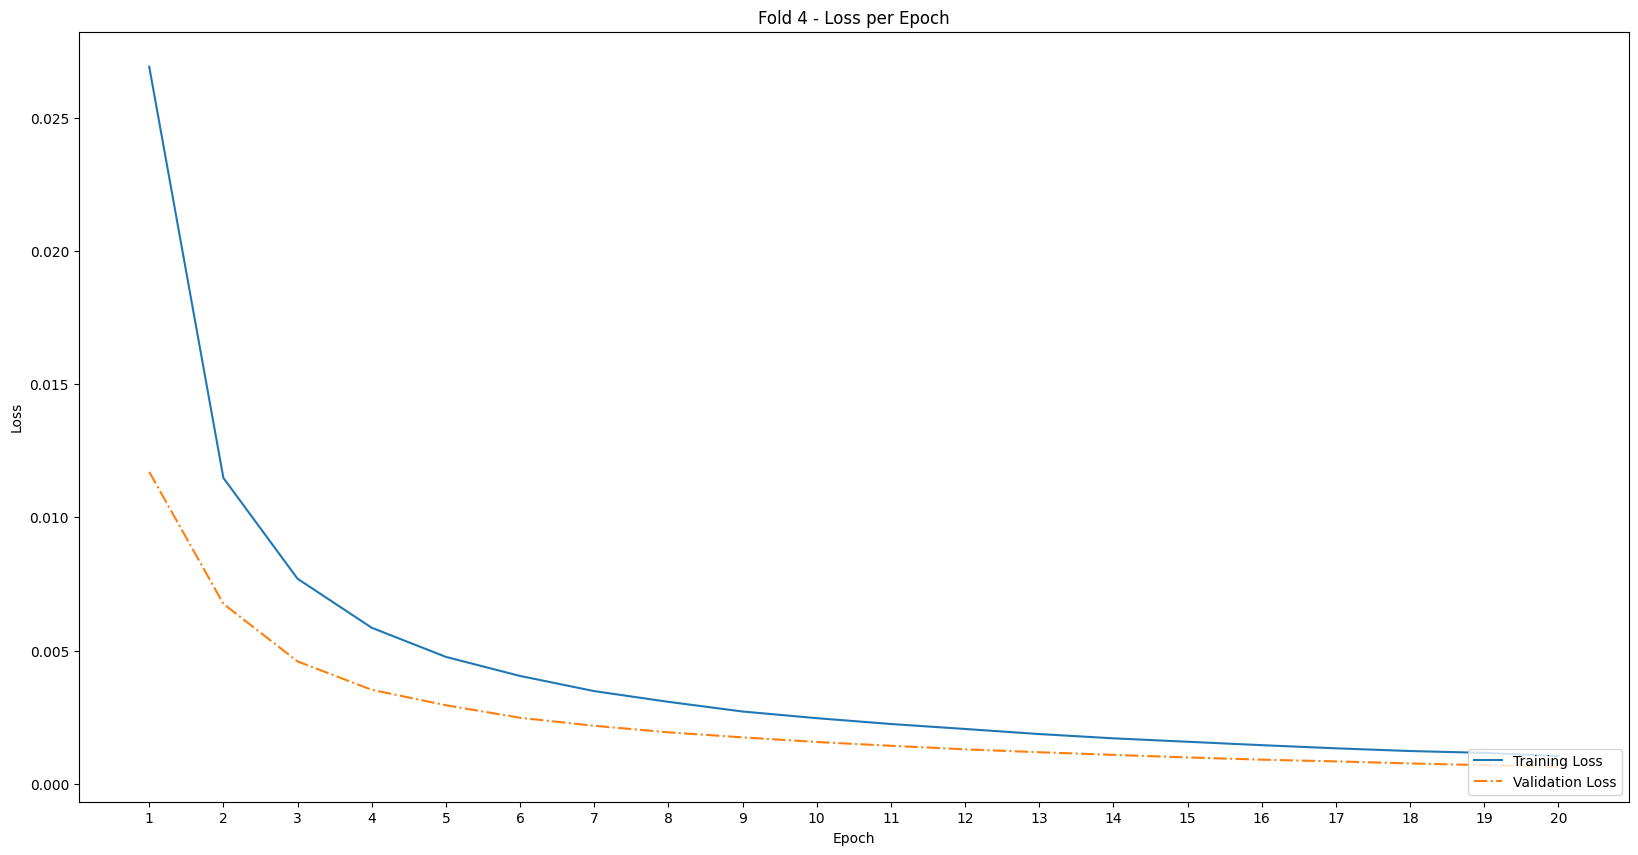

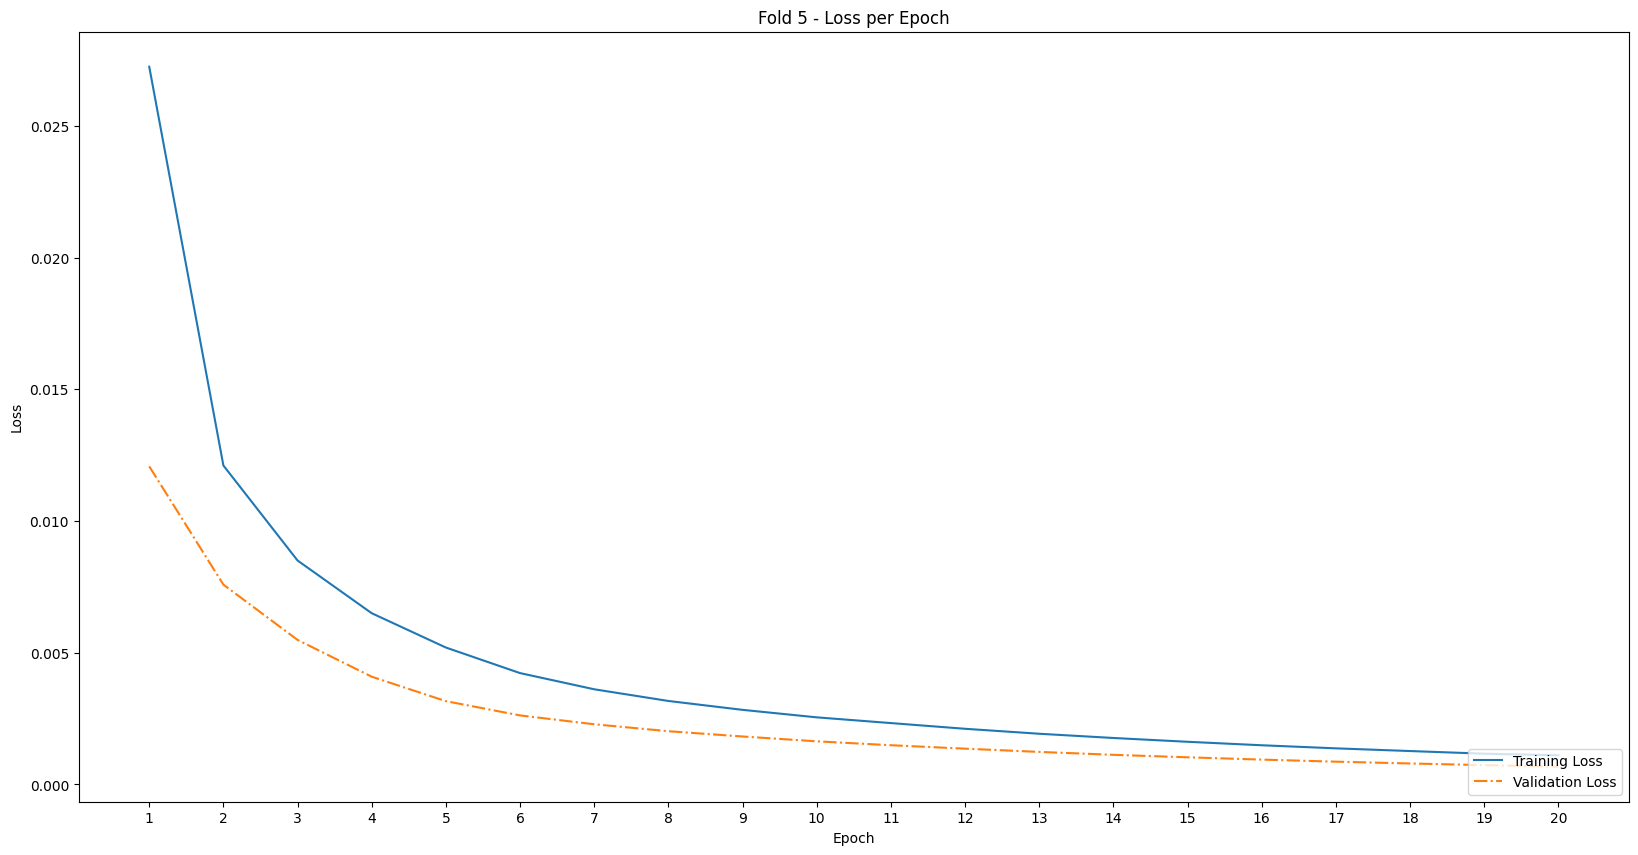

In [16]:
for i in range(5):
  x = np.arange(1, 21)
  y_train_loss = np.asarray(training_losses[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_losses[i], dtype=np.float32)

  plt.figure(figsize=(20,10))

  plt.plot(x, y_train_loss[0:20])
  plt.plot(x, y_val_loss[0:20], '-.')

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'Fold {i + 1} - Loss per Epoch')
  plt.show()

### Save Model

In [ ]:
# save_path = 'model/class/'
# !mkdir -p model/class/

# model_class_path = os.path.join(save_path, "multilingualbert_class_tesaurus"+".pth")

# model.to('cpu')
# torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Test


Average loss di testing data: 0.0006482186152846747


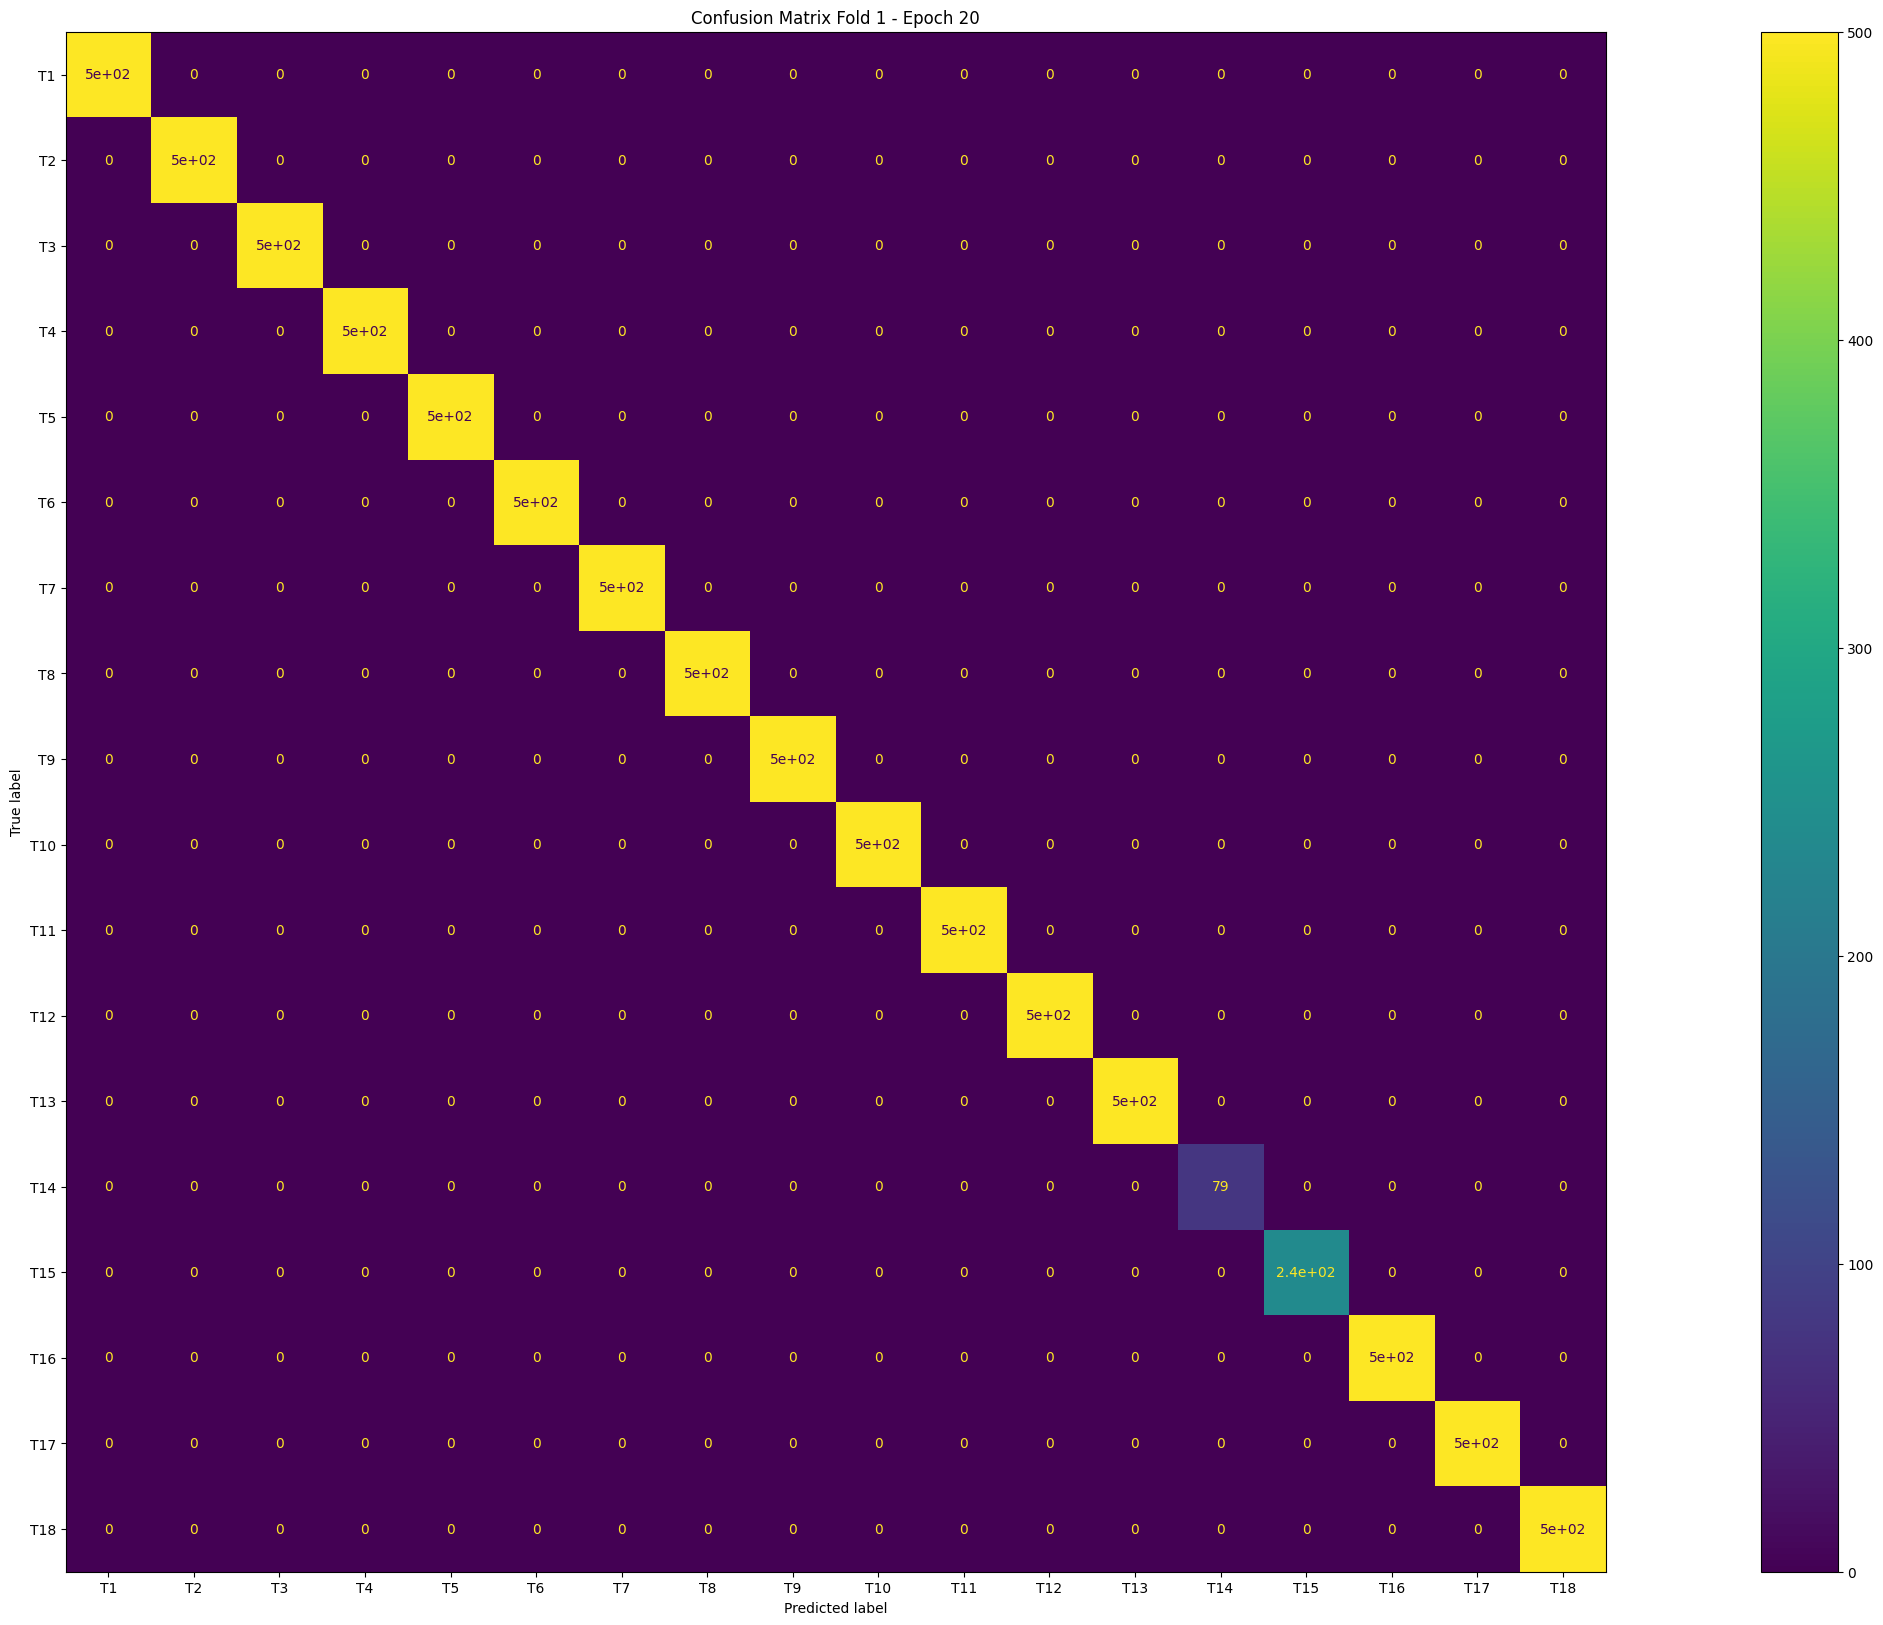

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.0,1.0,1.0,1.0
T2,500.0,1.0,1.0,1.0,1.0
T3,500.0,1.0,1.0,1.0,1.0
T4,500.0,1.0,1.0,1.0,1.0
T5,500.0,1.0,1.0,1.0,1.0
T6,500.0,1.0,1.0,1.0,1.0
T7,500.0,1.0,1.0,1.0,1.0
T8,500.0,1.0,1.0,1.0,1.0
T9,500.0,1.0,1.0,1.0,1.0
T10,500.0,1.0,1.0,1.0,1.0



Average loss di testing data: 0.0006503689202029248


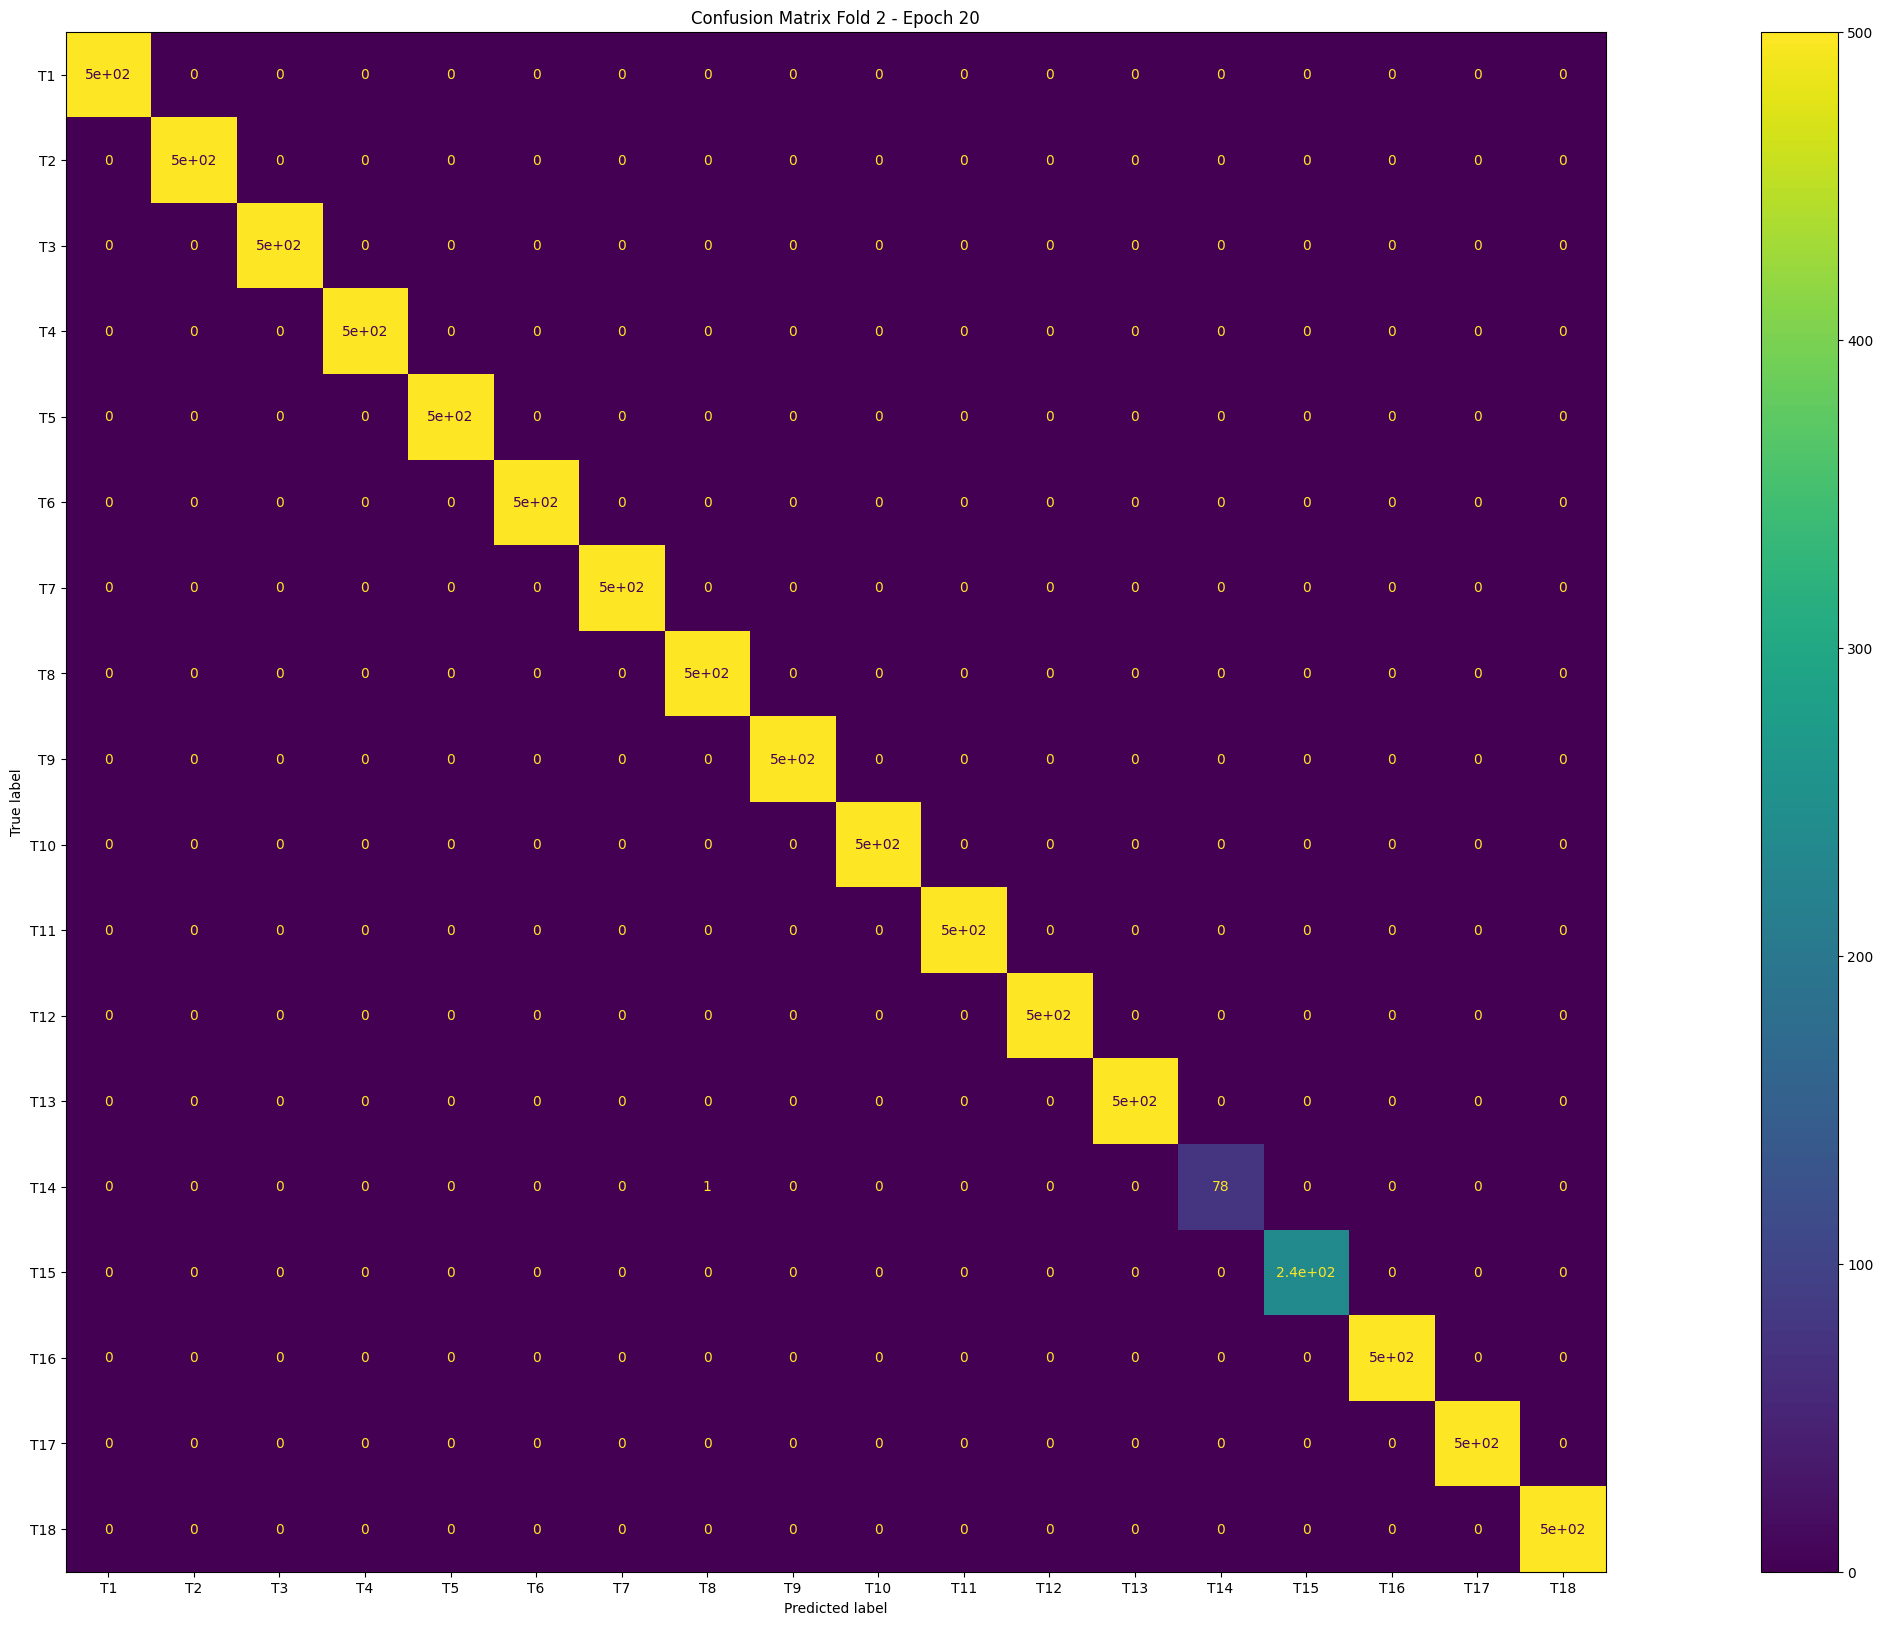

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.000000,1.000000,1.000000,1.000000
T2,500.0,1.000000,1.000000,1.000000,1.000000
T3,500.0,1.000000,1.000000,1.000000,1.000000
T4,500.0,1.000000,1.000000,1.000000,1.000000
T5,500.0,1.000000,1.000000,1.000000,1.000000
T6,500.0,1.000000,1.000000,1.000000,1.000000
T7,500.0,1.000000,1.000000,1.000000,1.000000
T8,500.0,1.000000,0.998004,1.000000,0.999001
T9,500.0,1.000000,1.000000,1.000000,1.000000
T10,500.0,1.000000,1.000000,1.000000,1.000000



Average loss di testing data: 0.000738785550424645


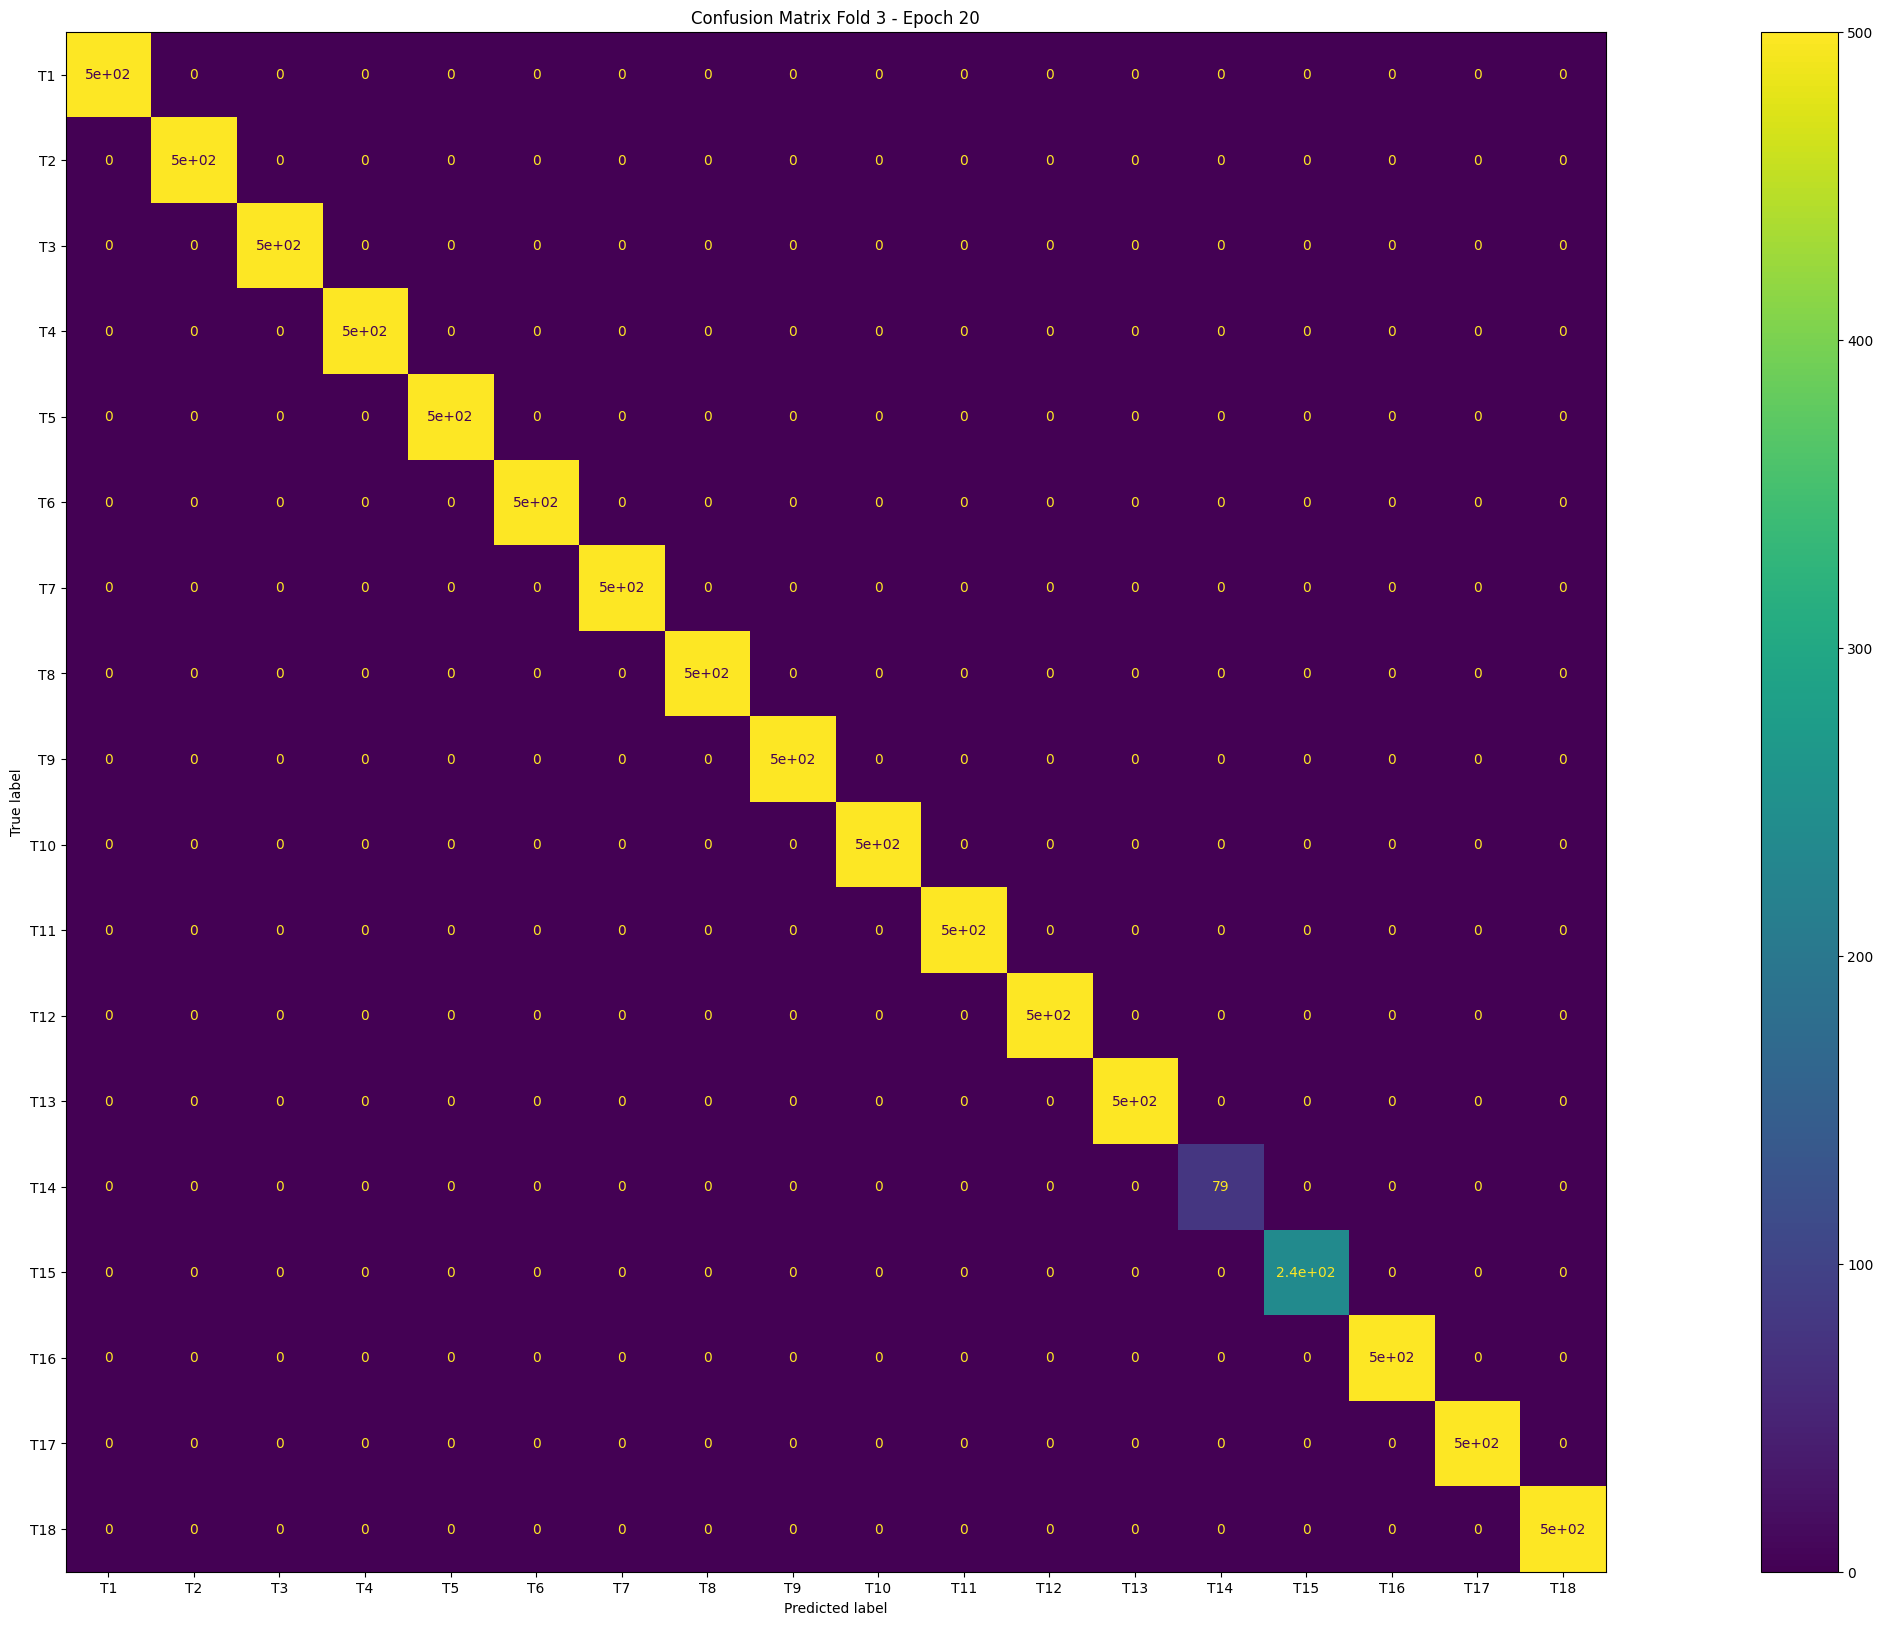

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.0,1.0,1.0,1.0
T2,500.0,1.0,1.0,1.0,1.0
T3,500.0,1.0,1.0,1.0,1.0
T4,500.0,1.0,1.0,1.0,1.0
T5,500.0,1.0,1.0,1.0,1.0
T6,500.0,1.0,1.0,1.0,1.0
T7,500.0,1.0,1.0,1.0,1.0
T8,500.0,1.0,1.0,1.0,1.0
T9,500.0,1.0,1.0,1.0,1.0
T10,500.0,1.0,1.0,1.0,1.0



Average loss di testing data: 0.0006411420761370894


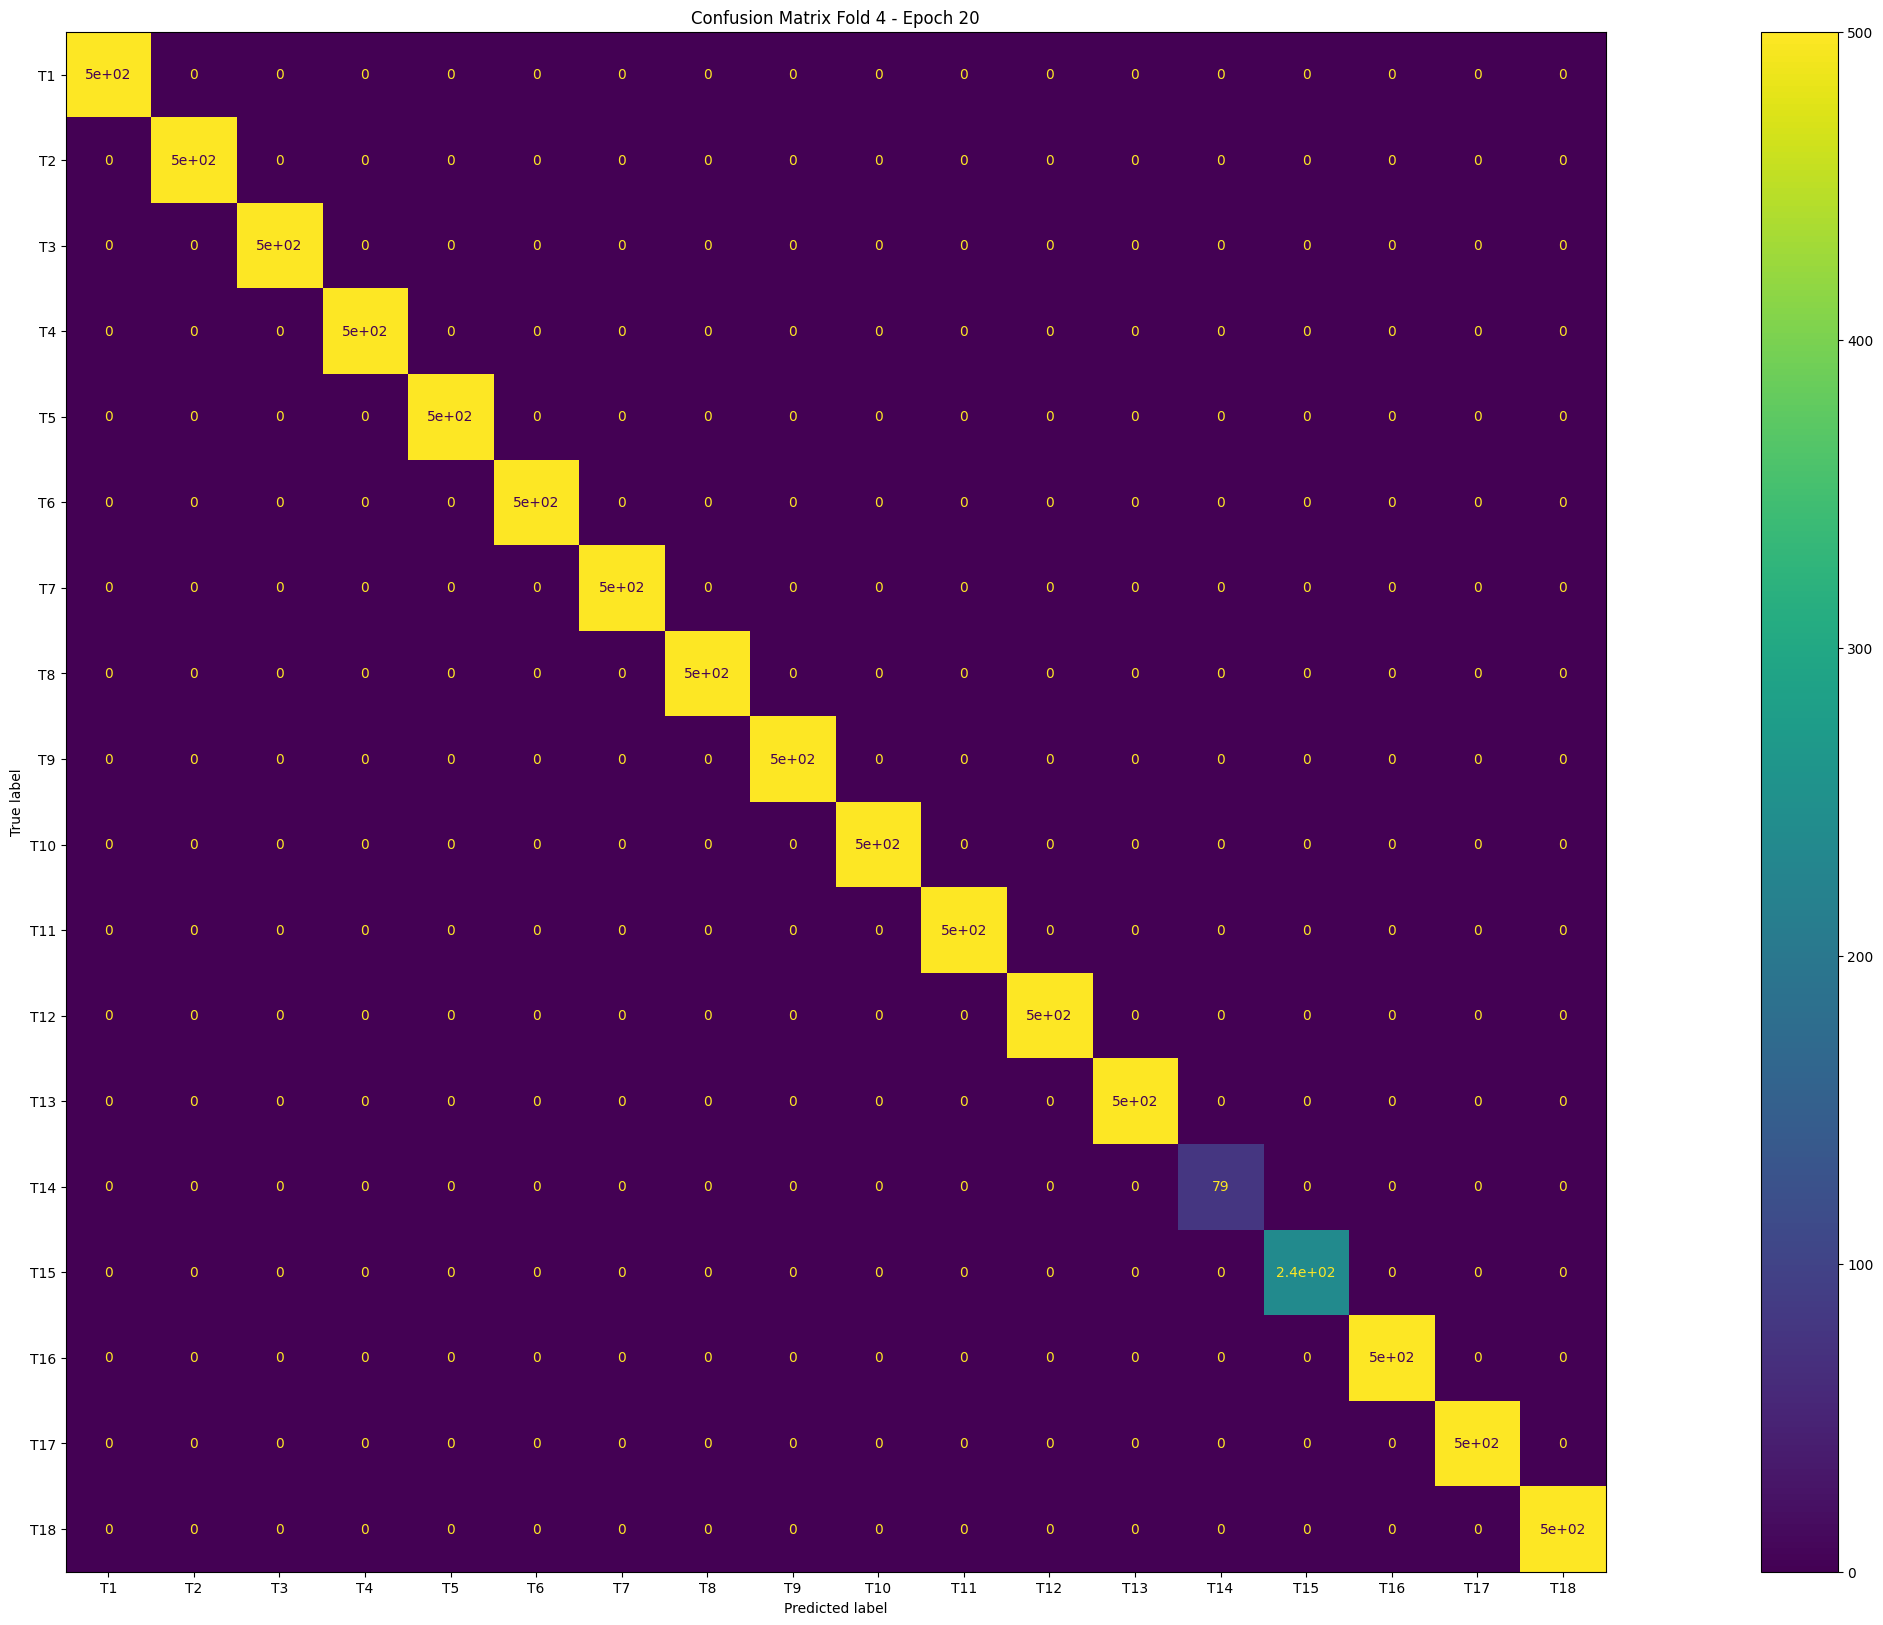

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.0,1.0,1.0,1.0
T2,500.0,1.0,1.0,1.0,1.0
T3,500.0,1.0,1.0,1.0,1.0
T4,500.0,1.0,1.0,1.0,1.0
T5,500.0,1.0,1.0,1.0,1.0
T6,500.0,1.0,1.0,1.0,1.0
T7,500.0,1.0,1.0,1.0,1.0
T8,500.0,1.0,1.0,1.0,1.0
T9,500.0,1.0,1.0,1.0,1.0
T10,500.0,1.0,1.0,1.0,1.0



Average loss di testing data: 0.0006696591953169013


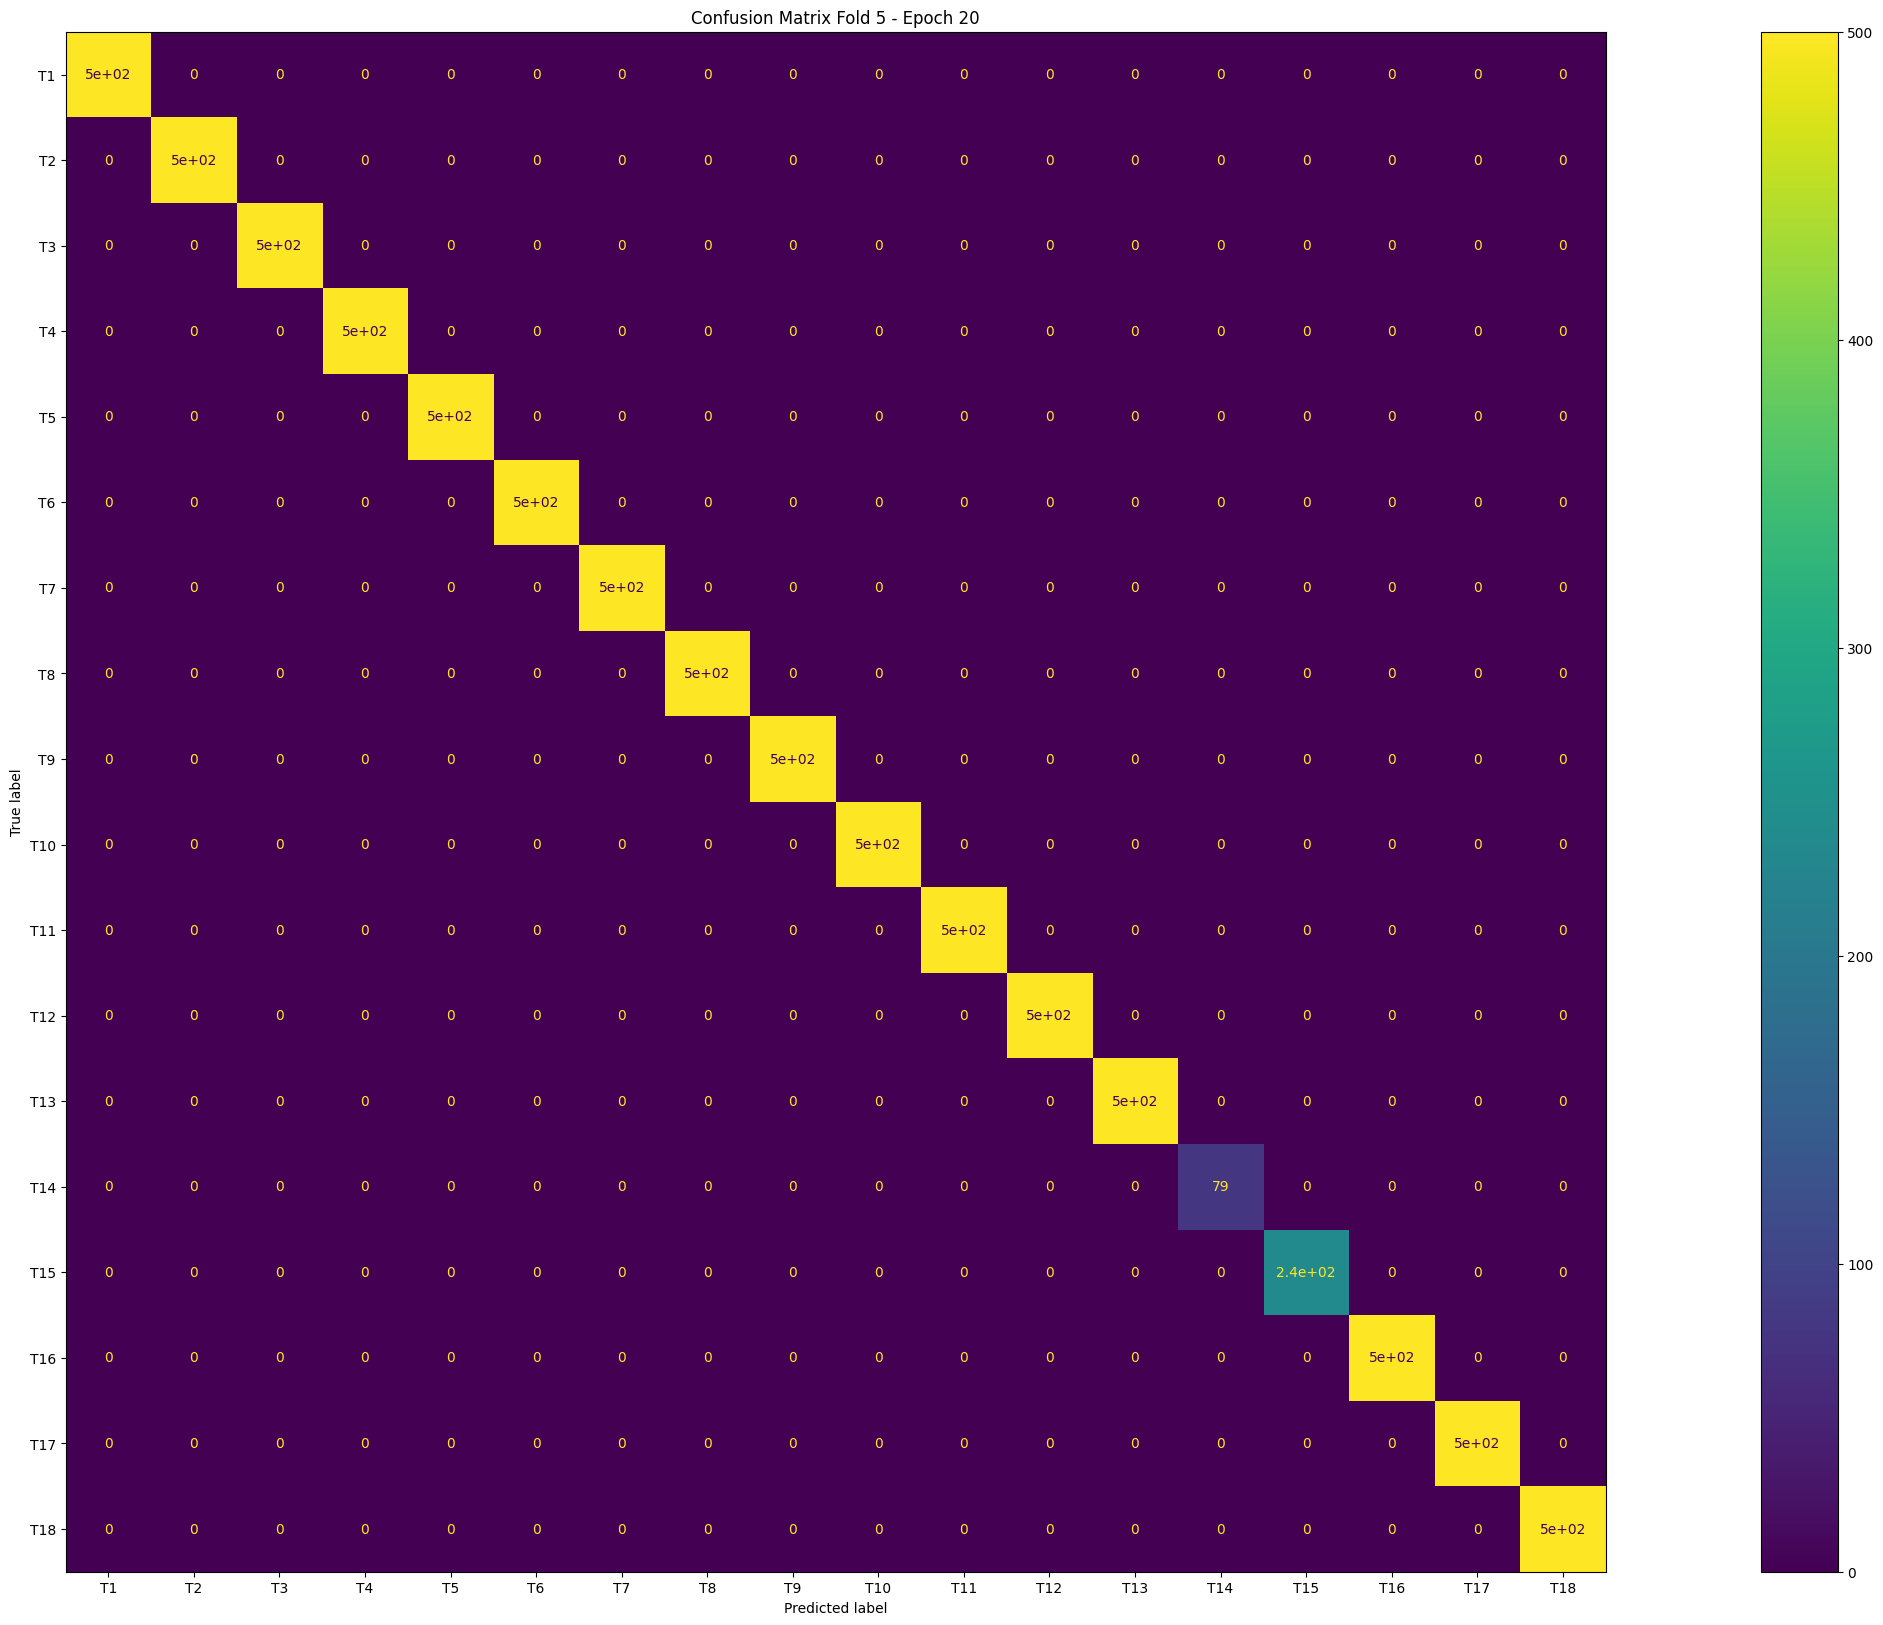

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.0,1.0,1.0,1.0
T2,500.0,1.0,1.0,1.0,1.0
T3,500.0,1.0,1.0,1.0,1.0
T4,500.0,1.0,1.0,1.0,1.0
T5,500.0,1.0,1.0,1.0,1.0
T6,500.0,1.0,1.0,1.0,1.0
T7,500.0,1.0,1.0,1.0,1.0
T8,500.0,1.0,1.0,1.0,1.0
T9,500.0,1.0,1.0,1.0,1.0
T10,500.0,1.0,1.0,1.0,1.0


In [17]:
for fold_i in range(5):

  tr_loss = 0

  save_path = 'model_multilingualbert/class_tesaurus_checkpoint/fold_' + str(fold_i)
  model_class_path = os.path.join(save_path, "multilingualbert_class_tesaurus_checkpoint_19.pth")
  model = torch.load(model_class_path)

  model.to(DEVICE)

  model.eval()

  nb_classes = 18

  true_recaps = [[] for i in range(5)]
  false_recaps = [[] for i in range(5)]

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      for input_recap, gold_recap, pred_recap in zip(input.to('cpu'), gold.to('cpu'), pred.to('cpu')):
        input_recap_sentence = tokenizer.decode(input_recap)
        _, gold_idx = torch.max(gold_recap, 0)
        _, pred_idx = torch.max(pred_recap, 0)
        if gold_idx == pred_idx:
          true_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))
        else:
          false_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
  data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print("")
  print(f"Average loss di testing data: {avg_loss}")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)
  plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch 20")

  plt.show()

  disp_df = pd.DataFrame(data=data_conf,
                          index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
  display(disp_df)

In [18]:
save_path = 'model_multilingualbert/class_tesaurus_checkpoint/fold_3'
model_class_path = os.path.join(save_path, "multilingualbert_class_tesaurus_checkpoint_19.pth")
model = torch.load(model_class_path)

# bert_class = model_class

save_path = 'model/class/'
!mkdir -p model/class/
model_class_path = os.path.join(save_path, "multilingualbert_class_tesaurus"+".pth")

model.to('cpu')
torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
df_true_recaps = pd.DataFrame(true_recaps[3], columns=['question', 'true_label', 'pred_label'])

save_path = 'dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_true_recaps.to_csv('dataset/multilingualbert_classification_true_recaps.csv', index=False)

In [20]:
df_false_recaps = pd.DataFrame(false_recaps[3], columns=['question', 'true_label', 'pred_label'])

save_path = 'dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_false_recaps.to_csv('dataset/multilingualbert_classification_false_recaps.csv', index=False)